In [1]:
%matplotlib inline

# Imports

In [2]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import torch
import os
import sys
import pickle

import warnings
warnings.simplefilter("ignore", UserWarning)

In [3]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from Utilities import util
from Utilities.rand_generators import GridGenerator
from Utilities.normalization import zscore_normalization, zscore_unnormalization
from Prior_optimization.priors import OptimGaussianPrior
from Samplers.likelihoods import LikGaussian
from Metrics.sampling import compute_rhat_regression
from Prior_optimization.optimisation_mapper import PriorOptimisationMapper
from Prior_optimization.wasserstein_mapper import MapperWasserstein
from Prior_optimization.gpr import GPR
from Prior_optimization.kernels import RBF
from Prior_optimization.mean_functions import Zero
from Full_stochasticity.Networks.mlp import MLP
from Partial_stochasticity.Networks.factorized_gaussian_reparam_mlp import FactorizedGaussianMLPReparameterization
from Partial_stochasticity.Networks.regression_net_masked import RegressionNetMasked
from Partial_stochasticity.Networks.mlp_masked import MLPMasked as MLPMPS
from Partial_stochasticity.Networks.mlp_masked_not_factorized import MLPMaskedNF as MLPMPSNF
from Partial_stochasticity.Networks.gaussian_reparam_mlp import GaussianMLPReparameterization as GMLPRPS
from Partial_stochasticity.Networks.mlp_fs_stoch import StochMLP
from Full_stochasticity.Networks.gaussian_reparam_mlp import GaussianMLPReparameterization as GMLPRFS
from Full_stochasticity.Networks.masked_mlp import MLPMasked as MLPMFS
from Full_stochasticity.Networks.regression_net import RegressionNet

In [5]:
os.chdir("..")

In [6]:
mpl.rcParams['figure.dpi'] = 300

In [7]:
OUT_DIR_PS = "./exp/1D_regression/partially_stochastic"
FIG_DIR_PS = os.path.join(OUT_DIR_PS, "figures")
util.ensure_dir(OUT_DIR_PS)
util.ensure_dir(FIG_DIR_PS)
OUT_DIR_FS = "./exp/1D_regression/fully_stochastic"
FIG_DIR_FS = os.path.join(OUT_DIR_FS, "figures")
util.ensure_dir(OUT_DIR_FS)
util.ensure_dir(FIG_DIR_FS)
OUT_DIR_PSS = "./exp/1D_regression/fully_stochastic_sparse"
FIG_DIR_PSS = os.path.join(OUT_DIR_PSS, "figures")
util.ensure_dir(OUT_DIR_PSS)
util.ensure_dir(FIG_DIR_PSS)
OUT_DIR_FLS = "./exp/1D_regression/first_layer_stochastic"
FIG_DIR_FLS = os.path.join(OUT_DIR_FLS, "figures")
util.ensure_dir(OUT_DIR_FLS)
util.ensure_dir(FIG_DIR_FLS)
OUT_DIR_EBSWD_FS = "./exp/1D_regression/fully_stochastic_ebswd"
FIG_DIR_EBSWD_FS = os.path.join(OUT_DIR_EBSWD_FS, "figures")
util.ensure_dir(OUT_DIR_EBSWD_FS)
util.ensure_dir(FIG_DIR_EBSWD_FS)
FIG_DIR = "./exp/1D_regression/"
util.ensure_dir(FIG_DIR)

In [8]:
# setting device on GPU if available, else CPU
n_gpu = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device} \n')

#Additional Info when using cuda
if device.type == 'cuda':
    n_gpu += torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('Number of available GPUs:', str(n_gpu))

Using device: cuda 

NVIDIA A100-SXM4-80GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Number of available GPUs: 1


# Utilities

In [9]:
def make_random_gap(X, gap_ratio=0.2):
    a,b = X.min(),X.max()
    gap_a = a + np.random.rand() * (b-a)*(1-gap_ratio)
    gap_b = gap_a + (b-a)*gap_ratio
    idx = np.logical_and(gap_a<X, X<gap_b)
    if gap_a-a > b-gap_b:
        X[idx] = a + np.random.rand(idx.sum()) * (gap_a-a)
    else:
        X[idx] = gap_b + np.random.rand(idx.sum()) * (b-gap_b)

def gp_sample(X, ampl=1, leng=1, sn2=0.1):
    n, x = X.shape[0], X / leng
    sum_xx = np.sum(x*x, 1).reshape(-1, 1).repeat(n, 1)
    D = sum_xx + sum_xx.transpose() - 2 * np.matmul(x, x.transpose())
    C = ampl**2 * np.exp(-0.5 * D) + np.eye(n) * sn2
    return np.random.multivariate_normal(np.zeros(n), C).reshape(-1, 1)

def plot_samples(X, samples, var=None, n_keep=12, color="xkcd:bluish", smooth_q=False, ax=None):
    if ax is None: 
        ax = plt.gca()
    if samples.ndim > 2:
        samples = samples.squeeze()
    n_keep = int(samples.shape[1]/10) if n_keep is None else n_keep
    keep_idx = np.random.permutation(samples.shape[1])[:n_keep]
    mu = samples.mean(1)
    if var is None:
        q=97.72  ## corresponds to 2 stdevs in Gaussian
        # q = 99.99  ## corresponds to 3 std
        Q = np.percentile(samples, [100-q, q], axis=1)
        # ub, lb = Q[1,:], Q[0,:]
        ub, lb = mu + 2 * samples.std(1), mu - 2 * samples.std(1)
        if smooth_q:
            lb = moving_average(lb)
            ub = moving_average(ub)
    else:
        ub = mu + 3 * np.sqrt(var)
        lb = mu - 3 * np.sqrt(var)
    ####
    ax.fill_between(X.flatten(), ub, lb, color=color, alpha=0.25, lw=0)
    ax.plot(X, samples[:, keep_idx], color=color, alpha=0.8)
    ax.plot(X, mu, color='xkcd:red')

# Generate Data

In [10]:
util.set_seed(1)

N = 64
M = 100
a, b = -10, 10

# Generate data
X = np.random.rand(N, 1) * (b-a) + a
make_random_gap(X, gap_ratio=0.4)
y = gp_sample(X, ampl=1.6, leng=1.8)
Xtest = np.linspace(a-5, b+5, M).reshape(-1, 1)
# Normalize the dataset
X_, X_mean, X_std = zscore_normalization(X)
y_, y_mean, y_std = zscore_normalization(y)
Xtest_, _, _ = zscore_normalization(Xtest, X_mean, X_std)

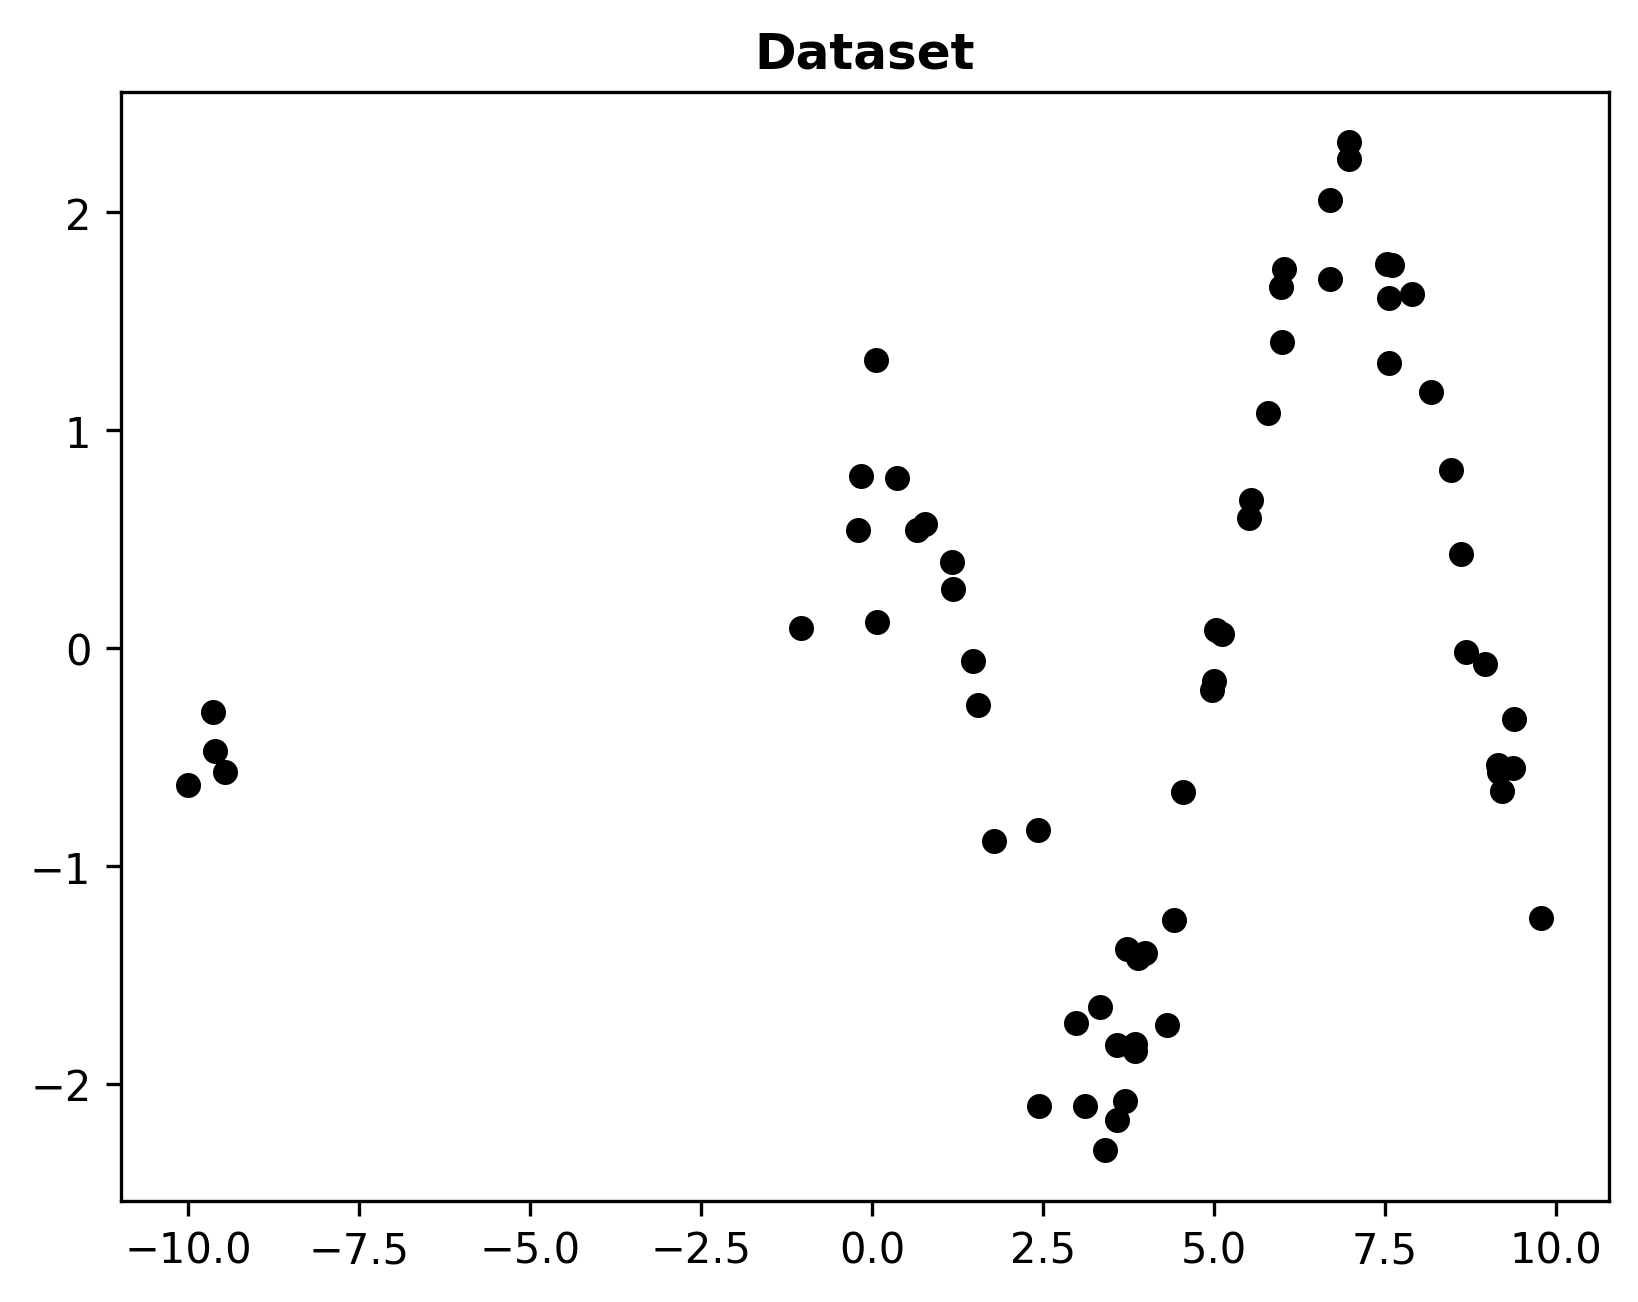

In [11]:
fig = plt.figure()
plt.plot(X, y, "ko", ms=5)
plt.title("Dataset", fontsize = 12, fontweight = 'bold')
plt.show()

In [12]:
Xtest_tensor = torch.from_numpy(Xtest_).to(device)

## Optimize the Prior for Partial Stochasticity

In [13]:
# Network setup
util.set_seed(1)
D = 3                   # The factorization depth
width = 50              # Number of units in each hidden layer
depth = 2               # Number of hidden layers
transfer_fn = "tanh"    # Activation function
X_tensor = torch.from_numpy(X).float().to(device)
y_tensor = torch.from_numpy(y).float().to(device)
data_generator = GridGenerator(-6, 6)

In [14]:
# Initialize BNN Priors
## All the sparse priors
opt_bnn_sp = FactorizedGaussianMLPReparameterization(input_dim=1, output_dim=1, D = D, activation_fn=transfer_fn, 
    hidden_dims=[width]*depth, device = device)
opt_bnn_sp = opt_bnn_sp.to(device)

opt_bnn_sp_level2 = FactorizedGaussianMLPReparameterization(input_dim=1, output_dim=1, D = D, activation_fn=transfer_fn, 
    hidden_dims=[width]*depth, device = device)
opt_bnn_sp_level2 = opt_bnn_sp_level2.to(device)

opt_bnn_sp_level3 = FactorizedGaussianMLPReparameterization(input_dim=1, output_dim=1, D = D, activation_fn=transfer_fn, 
    hidden_dims=[width]*depth, device = device)
opt_bnn_sp_level3 = opt_bnn_sp_level3.to(device)

opt_bnn_fs_ebswd = GMLPRFS(input_dim = 1, output_dim = 1, hidden_dims = [width]*depth, 
                                            activation_fn = transfer_fn)
opt_bnn_fs_ebswd = opt_bnn_fs_ebswd.to(device)

##

opt_bnn_fls = GMLPRPS(input_dim = 1, output_dim = 1, hidden_dims = [width]*depth, 
                                            activation_fn = transfer_fn)
opt_bnn_fls = opt_bnn_fls.to(device)

opt_bnn_fs = GMLPRFS(input_dim = 1, output_dim = 1, hidden_dims = [width]*depth, 
                                            activation_fn = transfer_fn)
opt_bnn_fs = opt_bnn_fs.to(device)

fixed_bnn_fs= GMLPRFS(input_dim=1, output_dim=1, activation_fn=transfer_fn, 
    hidden_dims=[width]*depth)
fixed_bnn_fs = fixed_bnn_fs.to(device)

fixed_bnn_fls = GMLPRPS(input_dim = 1, output_dim = 1, hidden_dims = [width]*depth, 
                                            activation_fn = transfer_fn)
fixed_bnn_fls = fixed_bnn_fls.to(device)

In [15]:
# GP hyper-parameters
sn2 = 0.1   # noise variance

leng = 0.6  # lengthscale for partially stochastic model
ampl = 1.0  # amplitude for partially stochastic model

# Initialize GP Prior
kernel = RBF(
        input_dim=1, ARD=True,
        lengthscales=torch.tensor([leng], dtype=torch.double),
        variance=torch.tensor([ampl], dtype=torch.double))
gpmodel = GPR(X=torch.from_numpy(X_).to(device),
              Y=torch.from_numpy(y_).reshape([-1, 1]).to(device),
              kern=kernel, mean_function=Zero())
gpmodel.likelihood.variance.set(sn2)
gpmodel = gpmodel.to(device)

##  Optimize the Prior for sparse BNN

### Level of Sparsity of circa 50%

In [16]:
# Configurations for the prior optimization
prior_opt_configurations = {
    "n_data": 128,                                          # The batch size 
    "num_iters": 5000,                                      # The number of iterations of the prior optimization
    "output_dim": 1,                                        # The dimension of the output
    "lambd": (torch.tensor([1.5, 1.75, 2.])/D).to(device),      # The regularization parameters for the layers
    "n_samples": 100,                                       # The number of function samples
    "lr": 3e-2,                                             # The learning rate for the optimizer
    "print_every": 100,                                     # After how many epochs a evaluation should be printed
    "save_ckpt_every": 500                                  # After how many epochs a checkpoint should be saved
}


In [17]:
# Initiialize the KLE optimizer
util.set_seed(1)
mapper = PriorOptimisationMapper(out_dir=OUT_DIR_PS, device=device, gp = gpmodel, out_det=False).to(device)
# Start optimizing the prior
p_hist, loss_hist = mapper.optimize(opt_bnn_sp, data_generator,**prior_opt_configurations)
loss_path_ps = os.path.join(OUT_DIR_PS, "loss_values.log")
loss_path_pss = os.path.join(OUT_DIR_PSS, "loss_values.log")
np.savetxt(loss_path_ps, loss_hist, fmt='%.6e')  
np.savetxt(loss_path_pss, loss_hist, fmt='%.6e')      
pruned_path_ps = os.path.join(OUT_DIR_PS, "pruned_values.log")
pruned_path_pss = os.path.join(OUT_DIR_PSS, "pruned_values.log")
np.savetxt(pruned_path_ps, p_hist, fmt='%.6e')   
np.savetxt(pruned_path_pss, p_hist, fmt='%.6e')   
with open(os.path.join(OUT_DIR_PS, "masks_list.pkl"), "wb") as f:
    pickle.dump(opt_bnn_sp.get_det_masks(), f)

>>> Iteration #   1: Energy-Based Sliced Wasserstein Distance 12.2609 Number of pruned stochastic weights: 0
>>> Iteration # 100: Energy-Based Sliced Wasserstein Distance 5.0750 Number of pruned stochastic weights: 0
>>> Iteration # 200: Energy-Based Sliced Wasserstein Distance 5.2679 Number of pruned stochastic weights: 2
>>> Iteration # 300: Energy-Based Sliced Wasserstein Distance 9.5313 Number of pruned stochastic weights: 4
>>> Iteration # 400: Energy-Based Sliced Wasserstein Distance 7.5921 Number of pruned stochastic weights: 5
>>> Iteration # 500: Energy-Based Sliced Wasserstein Distance 8.4373 Number of pruned stochastic weights: 6
>>> Iteration # 600: Energy-Based Sliced Wasserstein Distance 8.4089 Number of pruned stochastic weights: 12
>>> Iteration # 700: Energy-Based Sliced Wasserstein Distance 5.6392 Number of pruned stochastic weights: 18
>>> Iteration # 800: Energy-Based Sliced Wasserstein Distance 5.8133 Number of pruned stochastic weights: 27
>>> Iteration # 900: Ene

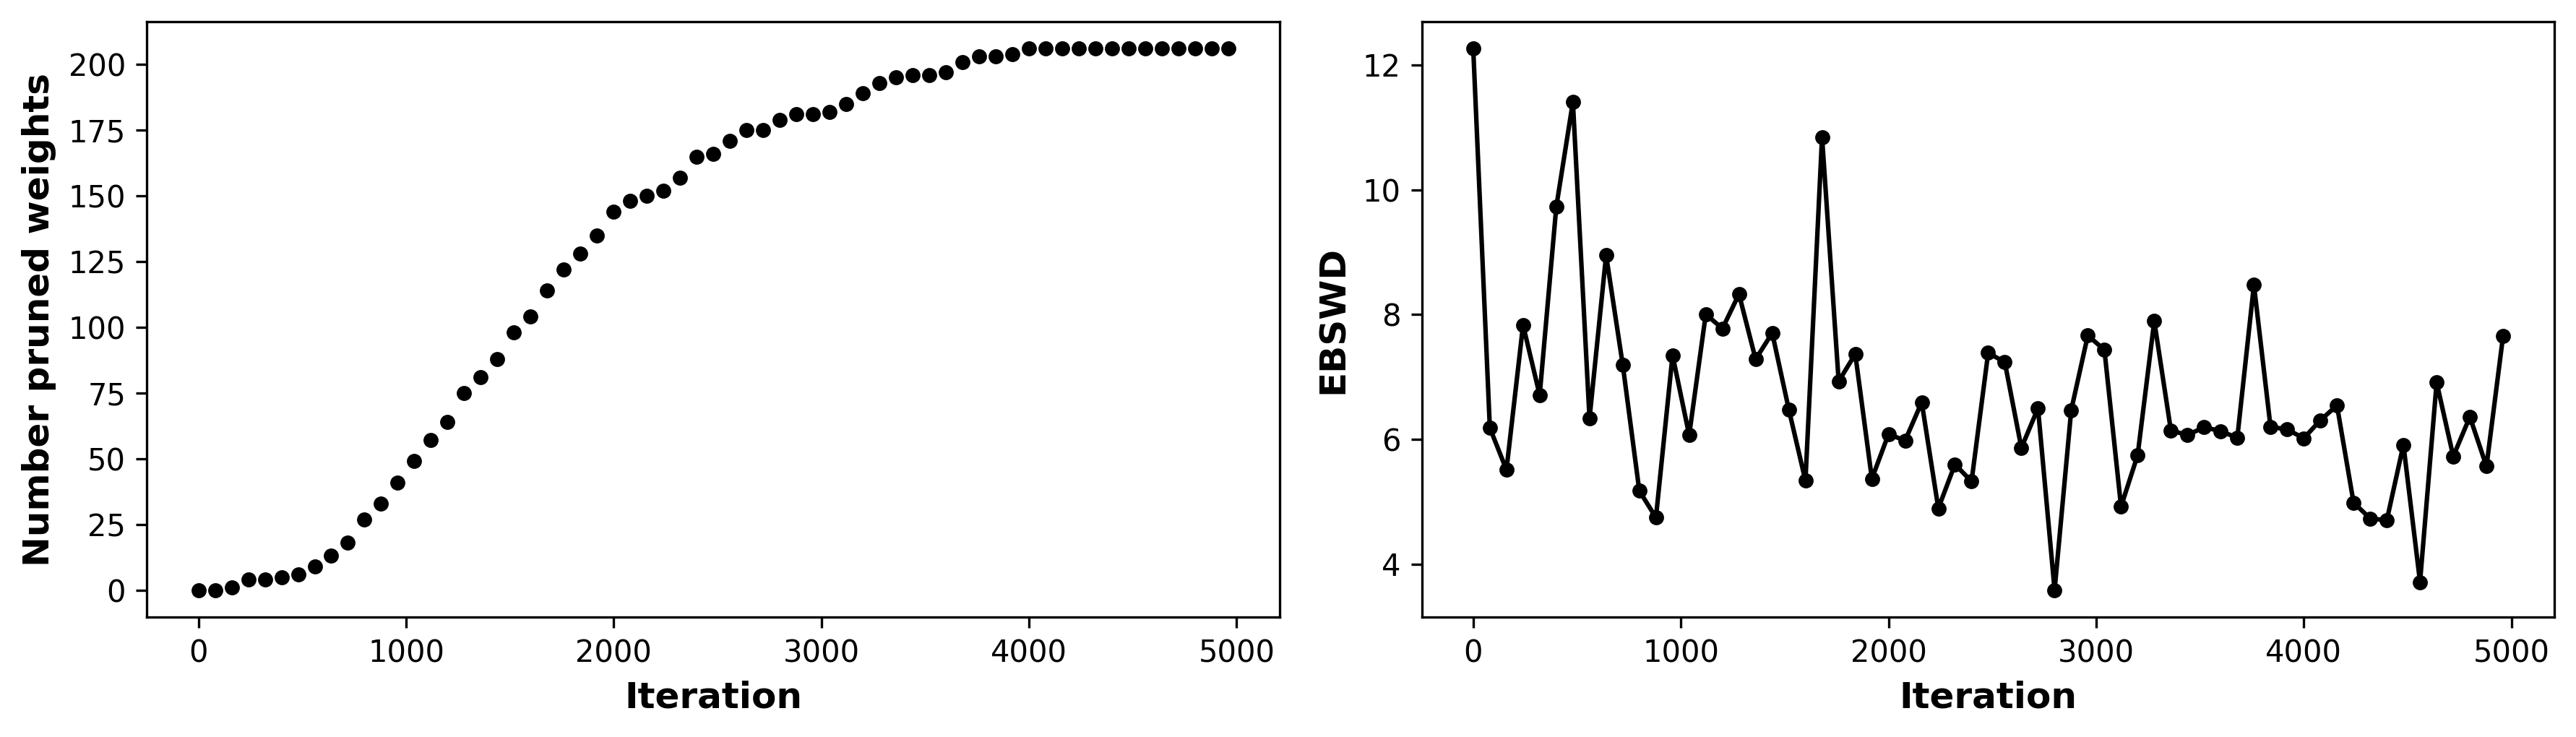

In [18]:
# Visualize progression of the prior optimization
num_iters_sp = prior_opt_configurations["num_iters"]
loss_hist = np.loadtxt(loss_path_ps)
p_hist = np.loadtxt(pruned_path_pss)

indices = np.arange(num_iters_sp)[::80]

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))  
axes[0].plot(indices, p_hist[indices], "ko", ms=4)
axes[0].set_ylabel("Number pruned weights", fontsize = 12, fontweight = 'bold')
axes[0].set_xlabel("Iteration", fontsize = 12, fontweight = 'bold')
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axes[1].plot(indices, loss_hist[indices], "-ko", ms=4)
axes[1].set_ylabel("EBSWD", fontsize = 12, fontweight = 'bold')
axes[1].set_xlabel("Iteration", fontsize = 12, fontweight = 'bold')

plt.tight_layout()
fig_path_ps = os.path.join(FIG_DIR_PS, "prior_optimization")
fig_path_pss = os.path.join(FIG_DIR_PSS, "prior_optimization")
plt.savefig(fig_path_ps)
plt.savefig(fig_path_pss)
plt.show()

### Level of Sparsity of crica 33%

In [19]:
# Configurations for the prior optimization
prior_opt_configurations = {
    "n_data": 128,                                          # The batch size 
    "num_iters": 5000,                                      # The number of iterations of the prior optimization
    "output_dim": 1,                                        # The dimension of the output
    "lambd": (torch.tensor([1.0, 1.3, 1.7])/D).to(device),      # The regularization parameters for the layers
    "n_samples": 100,                                       # The number of function samples
    "lr": 2e-2,                                             # The learning rate for the optimizer
    "print_every": 100,                                     # After how many epochs a evaluation should be printed
    "save_ckpt_every": 500                                  # After how many epochs a checkpoint should be saved
}


In [20]:
# Initiialize the KLE optimizer
util.set_seed(1)
saved_dir_ps_level2 = os.path.join(OUT_DIR_PS, "level2")
util.ensure_dir(saved_dir_ps_level2)
saved_dir_pss = os.path.join(OUT_DIR_PSS, "level2")
util.ensure_dir(saved_dir_pss)
mapper = PriorOptimisationMapper(out_dir=saved_dir_ps_level2, device=device, gp = gpmodel, out_det=False).to(device)
# Start optimizing the prior
p_hist, loss_hist = mapper.optimize(opt_bnn_sp_level2, data_generator,**prior_opt_configurations)
loss_path_ps = os.path.join(saved_dir_ps_level2, "loss_values.log")
loss_path_pss = os.path.join(saved_dir_pss, "loss_values.log")
np.savetxt(loss_path_ps, loss_hist, fmt='%.6e')  
np.savetxt(loss_path_pss, loss_hist, fmt='%.6e')      
pruned_path_ps = os.path.join(saved_dir_ps_level2, "pruned_values.log")
pruned_path_pss = os.path.join(saved_dir_pss, "pruned_values.log")
np.savetxt(pruned_path_ps, p_hist, fmt='%.6e')   
np.savetxt(pruned_path_pss, p_hist, fmt='%.6e')   
with open(os.path.join(saved_dir_ps_level2, "masks_list.pkl"), "wb") as f:
    pickle.dump(opt_bnn_sp_level2.get_det_masks(), f)

>>> Iteration #   1: Energy-Based Sliced Wasserstein Distance 12.4852 Number of pruned stochastic weights: 0
>>> Iteration # 100: Energy-Based Sliced Wasserstein Distance 5.3417 Number of pruned stochastic weights: 0
>>> Iteration # 200: Energy-Based Sliced Wasserstein Distance 5.6912 Number of pruned stochastic weights: 1
>>> Iteration # 300: Energy-Based Sliced Wasserstein Distance 8.4122 Number of pruned stochastic weights: 2
>>> Iteration # 400: Energy-Based Sliced Wasserstein Distance 6.7453 Number of pruned stochastic weights: 2
>>> Iteration # 500: Energy-Based Sliced Wasserstein Distance 7.9607 Number of pruned stochastic weights: 4
>>> Iteration # 600: Energy-Based Sliced Wasserstein Distance 6.8582 Number of pruned stochastic weights: 4
>>> Iteration # 700: Energy-Based Sliced Wasserstein Distance 4.1548 Number of pruned stochastic weights: 4
>>> Iteration # 800: Energy-Based Sliced Wasserstein Distance 6.1249 Number of pruned stochastic weights: 6
>>> Iteration # 900: Energy

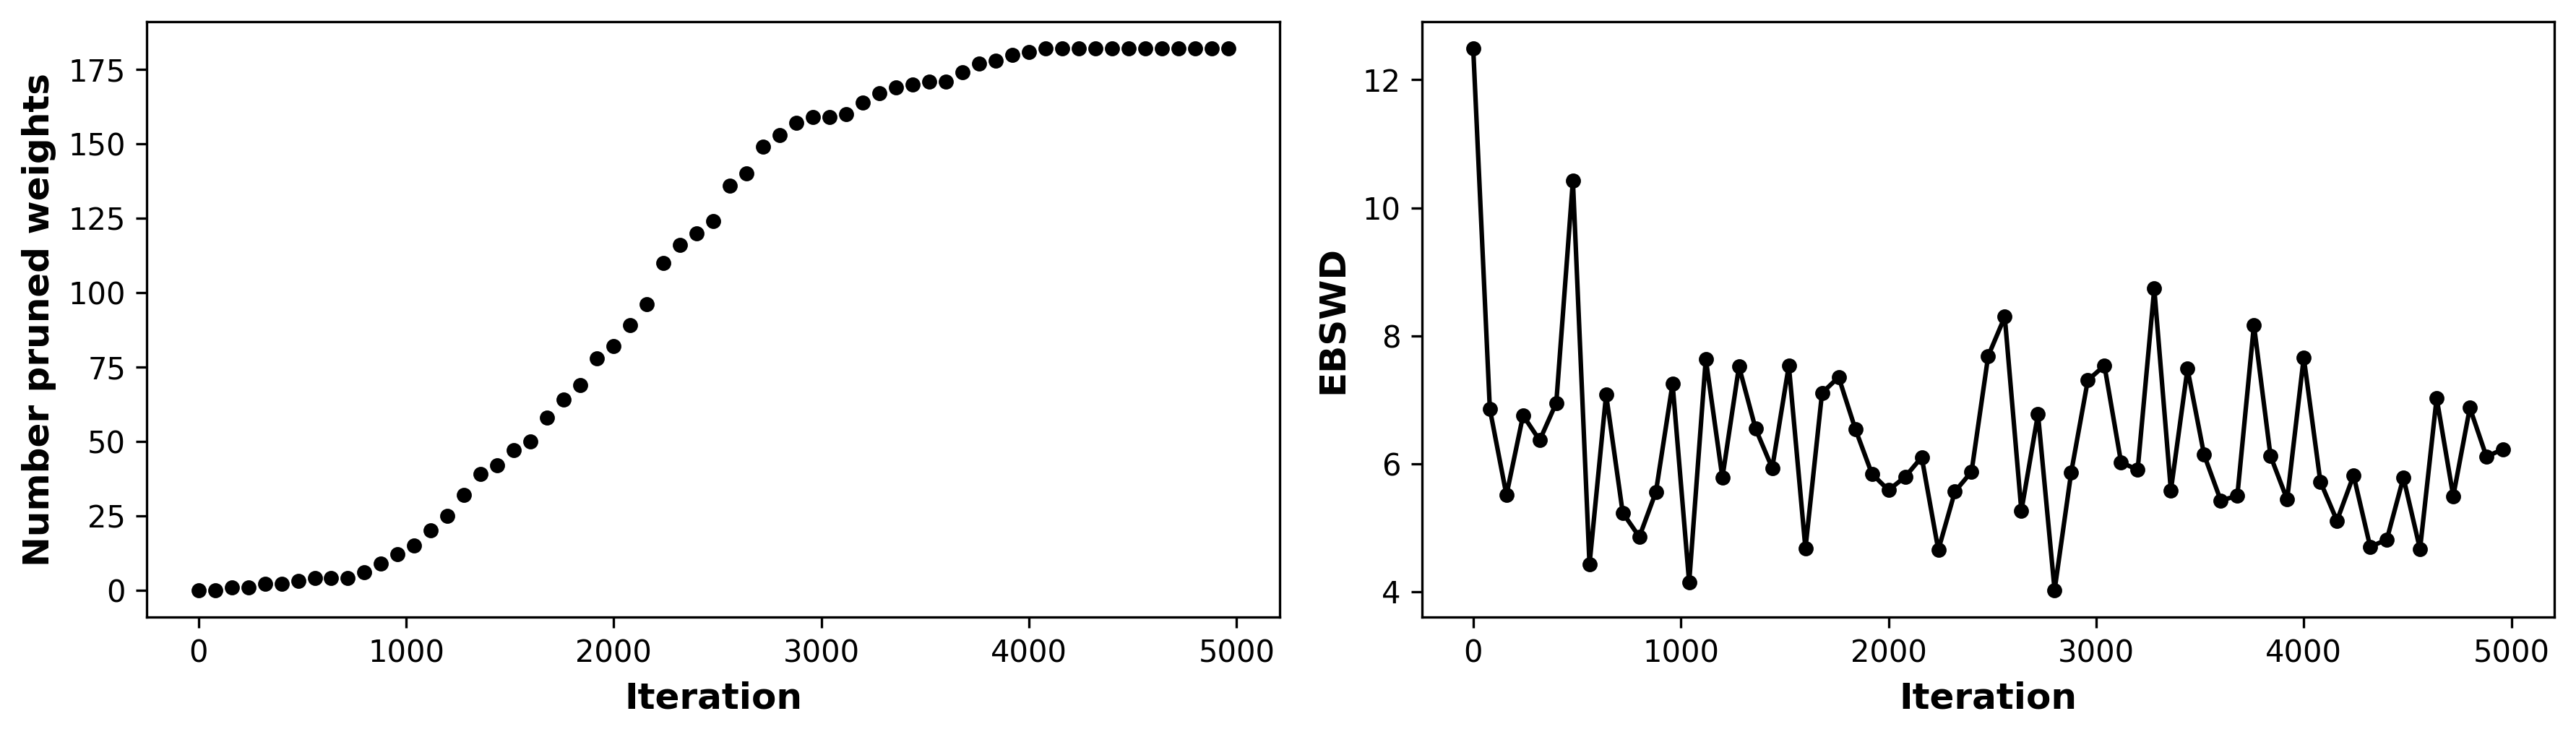

In [21]:
# Visualize progression of the prior optimization
fig_dir_ps = os.path.join(FIG_DIR_PS, "level2")
util.ensure_dir(fig_dir_ps)
fig_dir_pss = os.path.join(FIG_DIR_PSS, "level2")
util.ensure_dir(fig_dir_pss)
num_iters_sp = prior_opt_configurations["num_iters"]
loss_hist = np.loadtxt(loss_path_ps)
p_hist = np.loadtxt(pruned_path_pss)

indices = np.arange(num_iters_sp)[::80]

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))  
axes[0].plot(indices, p_hist[indices], "ko", ms=4)
axes[0].set_ylabel("Number pruned weights", fontsize = 12, fontweight = 'bold')
axes[0].set_xlabel("Iteration", fontsize = 12, fontweight = 'bold')
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axes[1].plot(indices, loss_hist[indices], "-ko", ms=4)
axes[1].set_ylabel("EBSWD", fontsize = 12, fontweight = 'bold')
axes[1].set_xlabel("Iteration", fontsize = 12, fontweight = 'bold')

plt.tight_layout()
fig_path_ps = os.path.join(fig_dir_ps, "prior_optimization")
fig_path_pss = os.path.join(fig_dir_pss, "prior_optimization")
plt.savefig(fig_path_ps)
plt.savefig(fig_path_pss)
plt.show()

### Level of Sparsity of circa 8%

In [22]:
# Configurations for the prior optimization
prior_opt_configurations = {
    "n_data": 128,                                          # The batch size 
    "num_iters": 5000,                                      # The number of iterations of the prior optimization
    "output_dim": 1,                                        # The dimension of the output
    "lambd": (torch.tensor([0.5, 0.75, 1.])/D).to(device),      # The regularization parameters for the layers
    "n_samples": 100,                                       # The number of function samples
    "lr": 1e-2,                                             # The learning rate for the optimizer
    "print_every": 100,                                     # After how many epochs a evaluation should be printed
    "save_ckpt_every": 500                                  # After how many epochs a checkpoint should be saved
}


In [23]:
# Initiialize the KLE optimizer
util.set_seed(1)
saved_dir_ps_level3 = os.path.join(OUT_DIR_PS, "level3")
util.ensure_dir(saved_dir_ps_level3)
saved_dir_pss = os.path.join(OUT_DIR_PSS, "level3")
util.ensure_dir(saved_dir_pss)
mapper = PriorOptimisationMapper(out_dir=saved_dir_ps_level3, device=device, gp = gpmodel, out_det=False).to(device)
# Start optimizing the prior
p_hist, loss_hist = mapper.optimize(opt_bnn_sp_level3, data_generator,**prior_opt_configurations)
loss_path_ps = os.path.join(saved_dir_ps_level3, "loss_values.log")
loss_path_pss = os.path.join(saved_dir_pss, "loss_values.log")
np.savetxt(loss_path_ps, loss_hist, fmt='%.6e')  
np.savetxt(loss_path_pss, loss_hist, fmt='%.6e')      
pruned_path_ps = os.path.join(saved_dir_ps_level3, "pruned_values.log")
pruned_path_pss = os.path.join(saved_dir_pss, "pruned_values.log")
np.savetxt(pruned_path_ps, p_hist, fmt='%.6e')   
np.savetxt(pruned_path_pss, p_hist, fmt='%.6e')   
with open(os.path.join(saved_dir_ps_level3, "masks_list.pkl"), "wb") as f:
    pickle.dump(opt_bnn_sp_level3.get_det_masks(), f)

>>> Iteration #   1: Energy-Based Sliced Wasserstein Distance 11.9449 Number of pruned stochastic weights: 0
>>> Iteration # 100: Energy-Based Sliced Wasserstein Distance 5.1920 Number of pruned stochastic weights: 0
>>> Iteration # 200: Energy-Based Sliced Wasserstein Distance 5.7900 Number of pruned stochastic weights: 0
>>> Iteration # 300: Energy-Based Sliced Wasserstein Distance 7.2461 Number of pruned stochastic weights: 0
>>> Iteration # 400: Energy-Based Sliced Wasserstein Distance 5.4998 Number of pruned stochastic weights: 0
>>> Iteration # 500: Energy-Based Sliced Wasserstein Distance 6.1503 Number of pruned stochastic weights: 0
>>> Iteration # 600: Energy-Based Sliced Wasserstein Distance 7.3734 Number of pruned stochastic weights: 0
>>> Iteration # 700: Energy-Based Sliced Wasserstein Distance 5.0530 Number of pruned stochastic weights: 0
>>> Iteration # 800: Energy-Based Sliced Wasserstein Distance 5.9013 Number of pruned stochastic weights: 0
>>> Iteration # 900: Energy

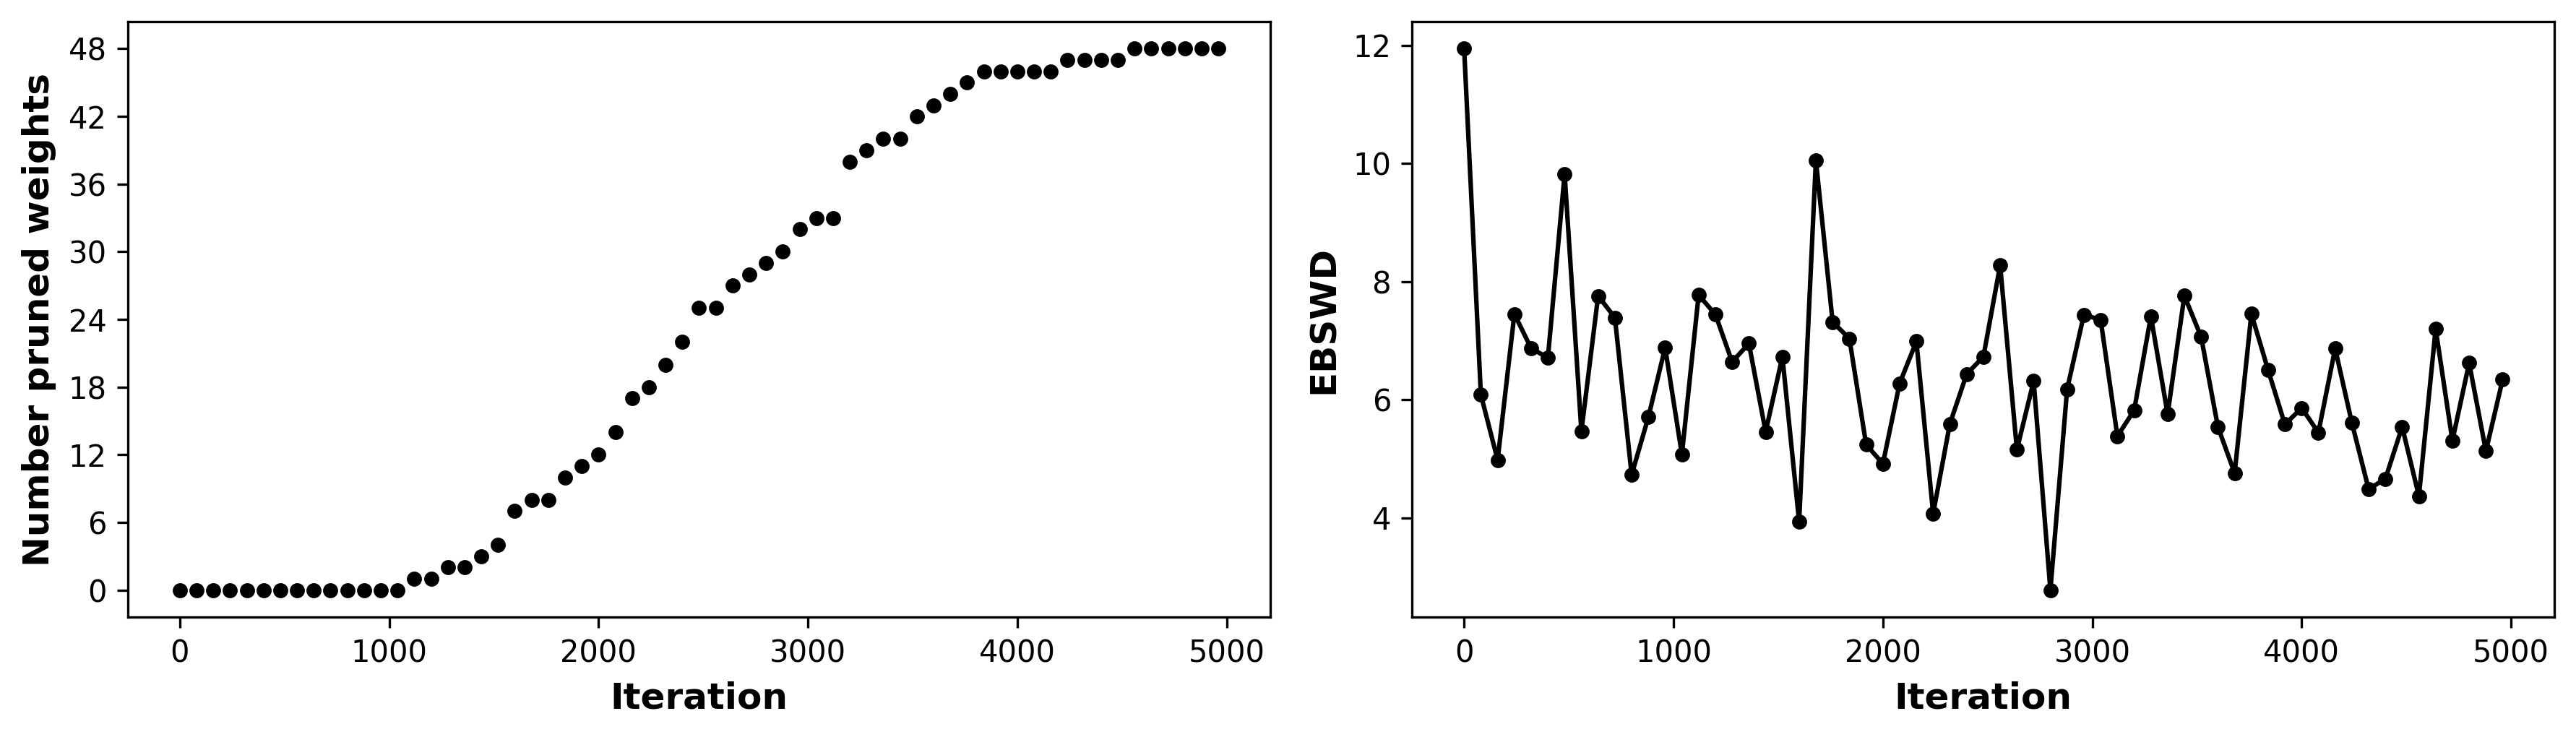

In [24]:
# Visualize progression of the prior optimization
fig_dir_ps = os.path.join(FIG_DIR_PS, "level3")
util.ensure_dir(fig_dir_ps)
fig_dir_pss = os.path.join(FIG_DIR_PSS, "level3")
util.ensure_dir(fig_dir_pss)
num_iters_sp = prior_opt_configurations["num_iters"]
loss_hist = np.loadtxt(loss_path_ps)
p_hist = np.loadtxt(pruned_path_pss)

indices = np.arange(num_iters_sp)[::80]

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))  
axes[0].plot(indices, p_hist[indices], "ko", ms=4)
axes[0].set_ylabel("Number pruned weights", fontsize = 12, fontweight = 'bold')
axes[0].set_xlabel("Iteration", fontsize = 12, fontweight = 'bold')
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axes[1].plot(indices, loss_hist[indices], "-ko", ms=4)
axes[1].set_ylabel("EBSWD", fontsize = 12, fontweight = 'bold')
axes[1].set_xlabel("Iteration", fontsize = 12, fontweight = 'bold')

plt.tight_layout()
fig_path_ps = os.path.join(fig_dir_ps, "prior_optimization")
fig_path_pss = os.path.join(fig_dir_pss, "prior_optimization")
plt.savefig(fig_path_ps)
plt.savefig(fig_path_pss)
plt.show()

### Level of Sparsity of 0%

In [25]:
# Configurations for the prior optimization
prior_opt_configurations = {
    "n_data": 128,                                          # The batch size 
    "num_iters": 5000,                                      # The number of iterations of the prior optimization
    "output_dim": 1,                                        # The dimension of the output
    "lambd": (torch.tensor([])/D).to(device),      # The regularization parameters for the layers
    "n_samples": 100,                                       # The number of function samples
    "lr": 1e-2,                                             # The learning rate for the optimizer
    "print_every": 100,                                     # After how many epochs a evaluation should be printed
    "save_ckpt_every": 500                                  # After how many epochs a checkpoint should be saved
}

In [26]:
util.set_seed(1)
mapper = PriorOptimisationMapper(out_dir=OUT_DIR_EBSWD_FS, device=device, gp = gpmodel, out_det=False).to(device)
# Start optimizing the prior
p_hist, loss_hist = mapper.optimize(opt_bnn_fs_ebswd, data_generator,**prior_opt_configurations)
loss_path_ps = os.path.join(OUT_DIR_EBSWD_FS, "loss_values.log")
np.savetxt(loss_path_ps, loss_hist, fmt='%.6e')  

>>> Iteration #   1: Energy-Based Sliced Wasserstein Distance 17.3638 Number of pruned stochastic weights: 0
>>> Iteration # 100: Energy-Based Sliced Wasserstein Distance 6.1021 Number of pruned stochastic weights: 0
>>> Iteration # 200: Energy-Based Sliced Wasserstein Distance 5.0854 Number of pruned stochastic weights: 0
>>> Iteration # 300: Energy-Based Sliced Wasserstein Distance 7.5548 Number of pruned stochastic weights: 0
>>> Iteration # 400: Energy-Based Sliced Wasserstein Distance 5.7252 Number of pruned stochastic weights: 0
>>> Iteration # 500: Energy-Based Sliced Wasserstein Distance 6.2884 Number of pruned stochastic weights: 0
>>> Iteration # 600: Energy-Based Sliced Wasserstein Distance 7.3786 Number of pruned stochastic weights: 0
>>> Iteration # 700: Energy-Based Sliced Wasserstein Distance 4.4090 Number of pruned stochastic weights: 0
>>> Iteration # 800: Energy-Based Sliced Wasserstein Distance 4.7639 Number of pruned stochastic weights: 0
>>> Iteration # 900: Energy

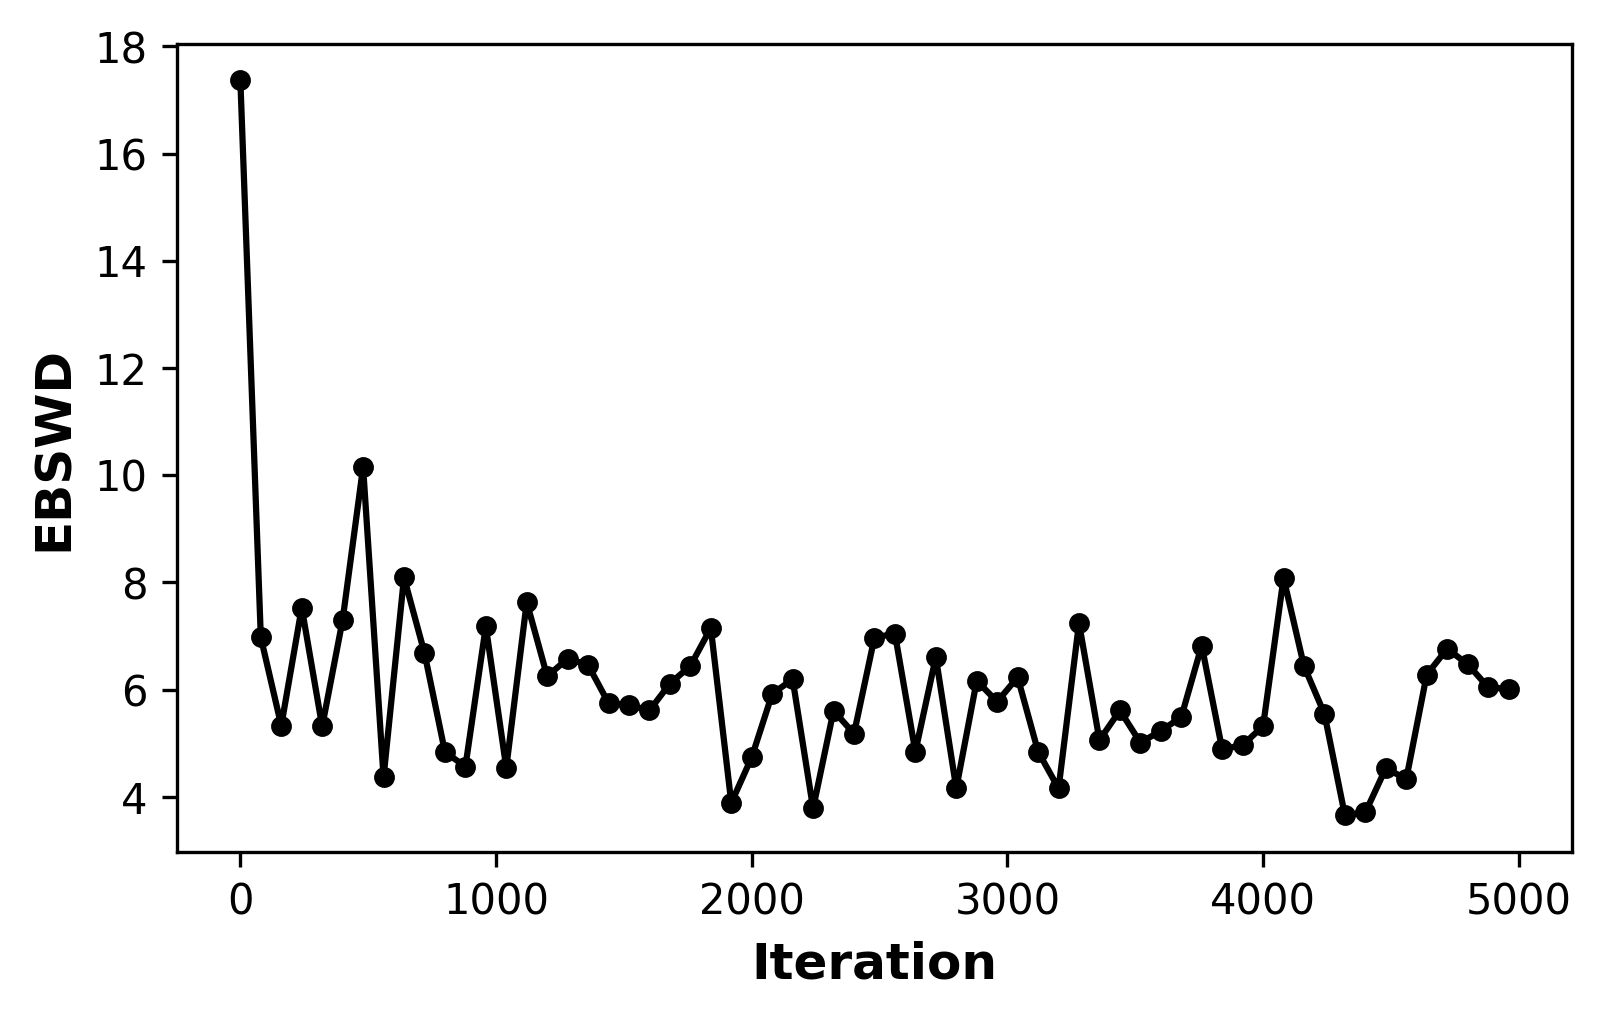

In [27]:
# Visualize progression of the prior optimization
wdist_file = os.path.join(OUT_DIR_EBSWD_FS, "loss_values.log")
wdist_vals = np.loadtxt(wdist_file)

fig = plt.figure(figsize=(6, 3.5))
indices = np.arange(num_iters_sp)[::80]
plt.plot(indices, wdist_vals[indices], "-ko", ms=4)
plt.ylabel("EBSWD", fontsize = 12, fontweight = 'bold')
plt.xlabel("Iteration", fontsize = 12, fontweight = 'bold')
fig_path = os.path.join(FIG_DIR_EBSWD_FS, "prior_optimization")
plt.savefig(fig_path)
plt.show()

## Optimize the Prior for Full BNN

### All Layers Stochastic

In [28]:
mapper_num_iters = 800 # Define the number of iterations of Wasserstein optimization

In [29]:
# Initiialize the Wasserstein optimizer
util.set_seed(1)
mapper = MapperWasserstein(gpmodel, opt_bnn_fs, data_generator,
                           out_dir=OUT_DIR_FS, 
                           wasserstein_steps=(0, 1000),
                           wasserstein_lr=0.08,
                           n_data=200, n_gpu=1, gpu_gp=True)

# Start optimizing the prior
w_hist = mapper.optimize(num_iters=mapper_num_iters, n_samples=512, lr=0.01, 
                         save_ckpt_every=50, print_every=20, debug=True)
wsr_path = os.path.join(OUT_DIR_FS, "wsr_values.log")
np.savetxt(wsr_path, w_hist, fmt='%.6e')       

>>> Iteration #   1: Wasserstein Dist 34.5429
>>> Iteration #  20: Wasserstein Dist 22.6244
>>> Iteration #  40: Wasserstein Dist 19.3580
>>> Iteration #  60: Wasserstein Dist 17.3391
>>> Iteration #  80: Wasserstein Dist 15.7443
>>> Iteration # 100: Wasserstein Dist 14.7961
>>> Iteration # 120: Wasserstein Dist 14.6553
>>> Iteration # 140: Wasserstein Dist 13.8471
>>> Iteration # 160: Wasserstein Dist 14.1635
>>> Iteration # 180: Wasserstein Dist 13.1852
>>> Iteration # 200: Wasserstein Dist 12.3456
>>> Iteration # 220: Wasserstein Dist 12.9731
>>> Iteration # 240: Wasserstein Dist 12.3652
>>> Iteration # 260: Wasserstein Dist 12.6947
>>> Iteration # 280: Wasserstein Dist 12.7227
>>> Iteration # 300: Wasserstein Dist 11.5976
>>> Iteration # 320: Wasserstein Dist 11.4311
>>> Iteration # 340: Wasserstein Dist 11.5322
>>> Iteration # 360: Wasserstein Dist 11.2610
>>> Iteration # 380: Wasserstein Dist 11.3195
>>> Iteration # 400: Wasserstein Dist 11.6254
>>> Iteration # 420: Wasserstein D

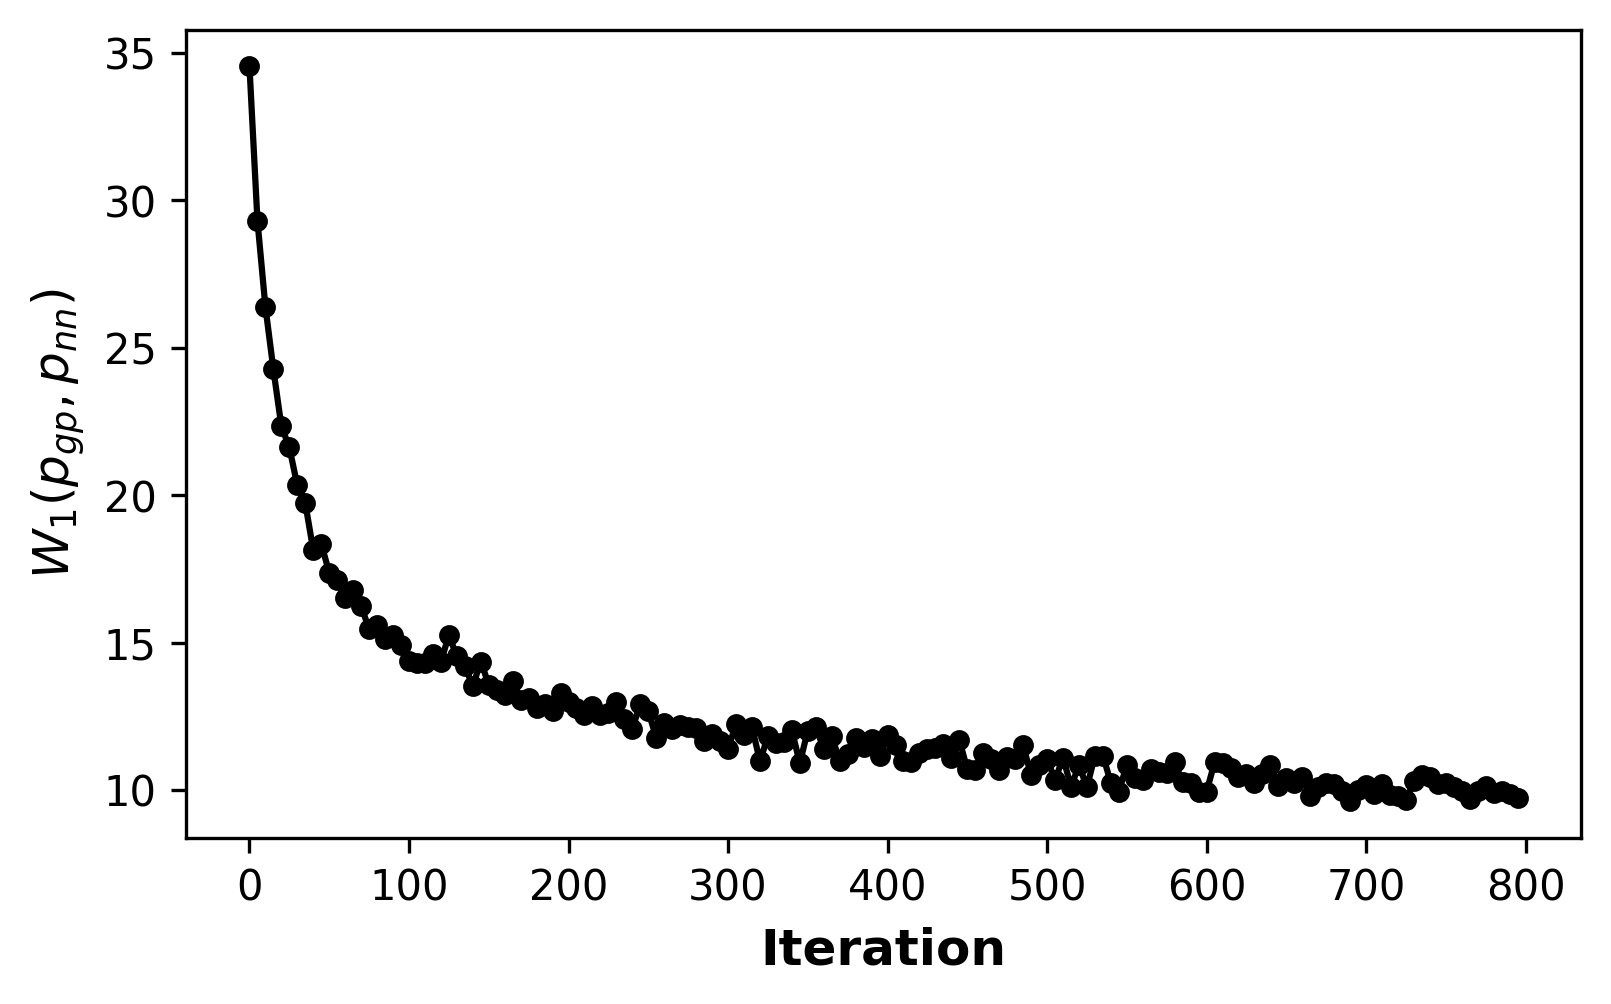

In [30]:
# Visualize progression of the prior optimization
wdist_file = os.path.join(OUT_DIR_FS, "wsr_values.log")
wdist_vals = np.loadtxt(wdist_file)

fig = plt.figure(figsize=(6, 3.5))
indices = np.arange(mapper_num_iters)[::5]
plt.plot(indices, wdist_vals[indices], "-ko", ms=4)
plt.ylabel(r"$W_1(p_{gp}, p_{nn})$", fontsize = 12, fontweight = 'bold')
plt.xlabel("Iteration", fontsize = 12, fontweight = 'bold')
fig_path = os.path.join(FIG_DIR_FS, "prior_optimization")
plt.savefig(fig_path)
plt.show()

### First Layer Stochastic

In [31]:
mapper_num_iters_fls = 800 # Define the number of iterations of Wasserstein optimization

In [32]:
# Initiialize the Wasserstein optimizer
util.set_seed(1)
mapper = MapperWasserstein(gpmodel, opt_bnn_fls, data_generator,
                           out_dir=OUT_DIR_FLS, 
                           wasserstein_steps=(0, 1000),
                           wasserstein_lr=0.08,
                           n_data=200, n_gpu=1, gpu_gp=True)

# Start optimizing the prior
w_hist = mapper.optimize(num_iters=mapper_num_iters_fls, n_samples=512, lr=0.01, 
                         save_ckpt_every=50, print_every=20, debug=True)
wsr_path = os.path.join(OUT_DIR_FLS, "wsr_values.log")
np.savetxt(wsr_path, w_hist, fmt='%.6e')       

>>> Iteration #   1: Wasserstein Dist 225.7045
>>> Iteration #  20: Wasserstein Dist 23.2564
>>> Iteration #  40: Wasserstein Dist 11.4265
>>> Iteration #  60: Wasserstein Dist 8.6527
>>> Iteration #  80: Wasserstein Dist 8.1252
>>> Iteration # 100: Wasserstein Dist 7.8764
>>> Iteration # 120: Wasserstein Dist 7.5501
>>> Iteration # 140: Wasserstein Dist 7.7053
>>> Iteration # 160: Wasserstein Dist 7.6332
>>> Iteration # 180: Wasserstein Dist 6.9416
>>> Iteration # 200: Wasserstein Dist 7.4103
>>> Iteration # 220: Wasserstein Dist 6.9670
>>> Iteration # 240: Wasserstein Dist 6.3385
>>> Iteration # 260: Wasserstein Dist 6.6573
>>> Iteration # 280: Wasserstein Dist 6.5051
>>> Iteration # 300: Wasserstein Dist 6.3242
>>> Iteration # 320: Wasserstein Dist 6.3411
>>> Iteration # 340: Wasserstein Dist 5.9413
>>> Iteration # 360: Wasserstein Dist 5.9260
>>> Iteration # 380: Wasserstein Dist 5.5045
>>> Iteration # 400: Wasserstein Dist 5.0089
>>> Iteration # 420: Wasserstein Dist 5.6756
>>> It

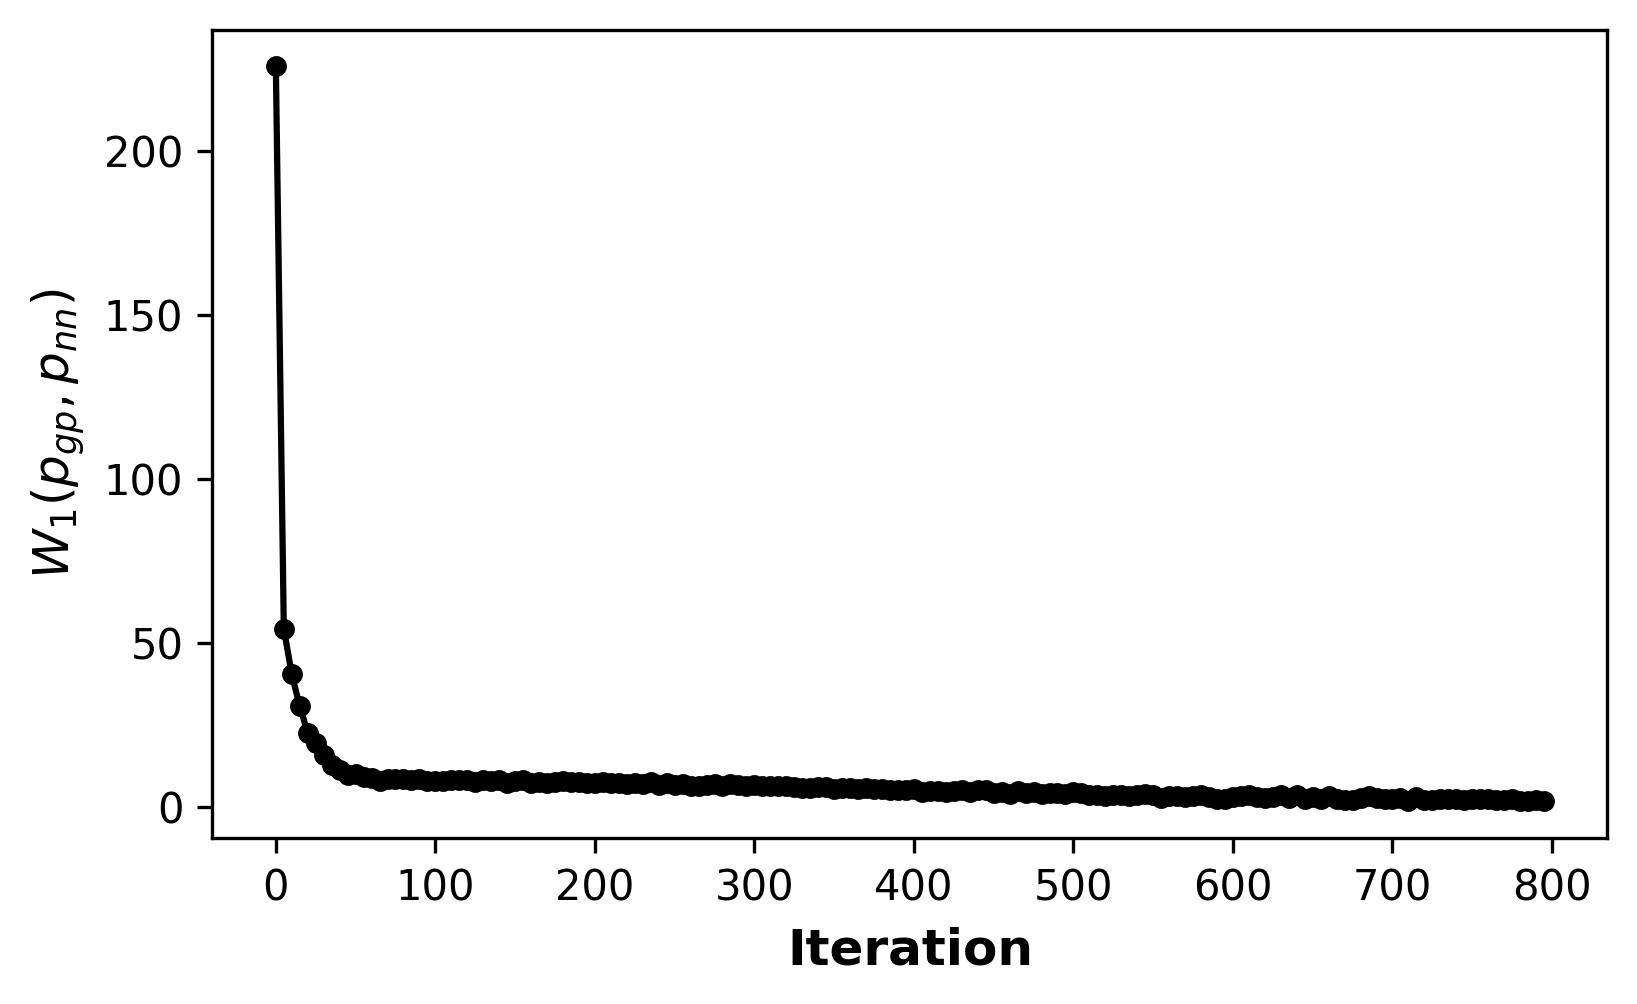

In [33]:
# Visualize progression of the prior optimization
wdist_file = os.path.join(OUT_DIR_FLS, "wsr_values.log")
wdist_vals = np.loadtxt(wdist_file)

fig = plt.figure(figsize=(6, 3.5))
indices = np.arange(mapper_num_iters_fls)[::5]
plt.plot(indices, wdist_vals[indices], "-ko", ms=4)
plt.ylabel(r"$W_1(p_{gp}, p_{nn})$", fontsize = 12, fontweight = 'bold')
plt.xlabel("Iteration", fontsize = 12, fontweight = 'bold')
fig_path = os.path.join(FIG_DIR_FLS, "prior_optimization")
plt.savefig(fig_path)
plt.show()

## Compare Functional Prior

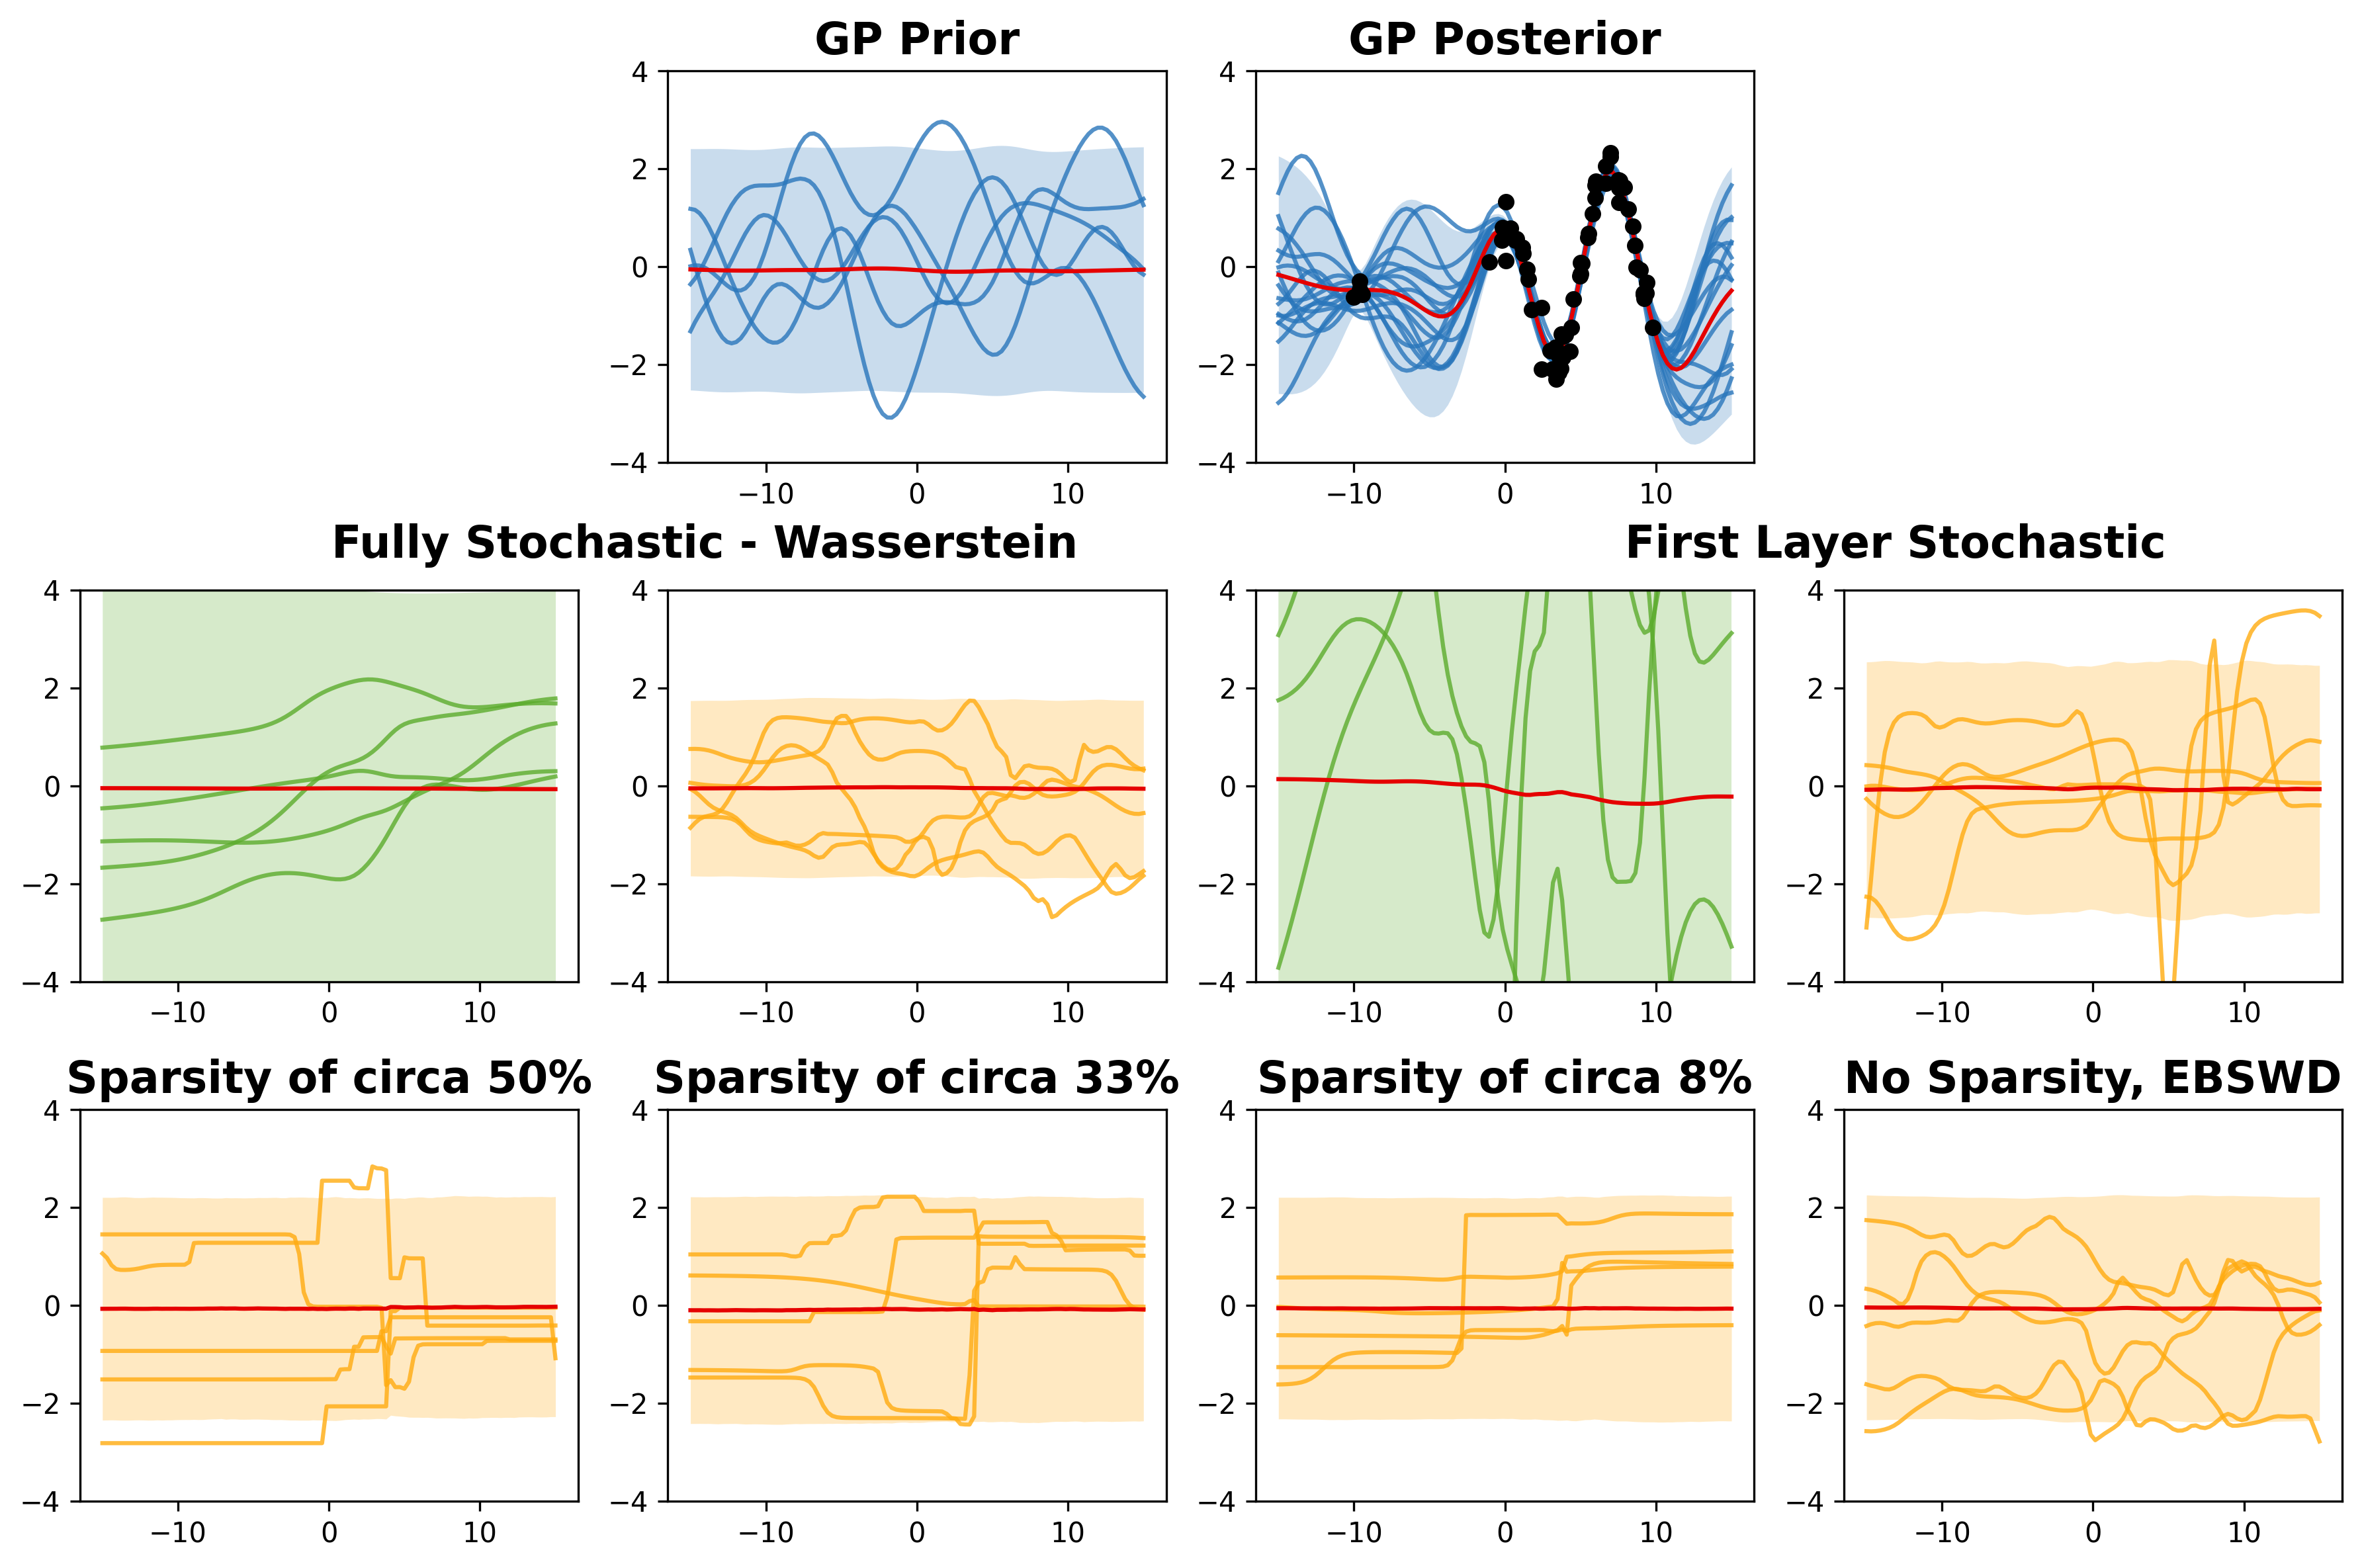

In [64]:
# Draw functions from the priors
util.set_seed(8)
n_plot = 4000

opt_bnn_samples_fls = opt_bnn_fls.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
opt_bnn_samples_fls = zscore_unnormalization(opt_bnn_samples_fls, y_mean, y_std)

fixed_bnn_samples_fs = fixed_bnn_fs.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
fixed_bnn_samples_fs = zscore_unnormalization(fixed_bnn_samples_fs, y_mean, y_std)

opt_samples_fs = opt_bnn_fs.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
opt_samples_fs = zscore_unnormalization(opt_samples_fs, y_mean, y_std)

fixed_bnn_samples_fls = fixed_bnn_fls.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
fixed_bnn_samples_fls = zscore_unnormalization(fixed_bnn_samples_fls, y_mean, y_std)

sparse_opt_samples = opt_bnn_sp.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
sparse_opt_samples = zscore_unnormalization(sparse_opt_samples, y_mean, y_std)

sparse_opt_samples_level2 = opt_bnn_sp_level2.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
sparse_opt_samples_level2 = zscore_unnormalization(sparse_opt_samples_level2, y_mean, y_std)

sparse_opt_samples_level3 = opt_bnn_sp_level3.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
sparse_opt_samples_level3 = zscore_unnormalization(sparse_opt_samples_level3, y_mean, y_std)

opt_samples_ebswd = opt_bnn_fs_ebswd.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
opt_samples_ebswd = zscore_unnormalization(opt_samples_ebswd, y_mean, y_std)
# GPs
gp_samples = gpmodel.sample_functions(
   Xtest_tensor, n_plot).detach().cpu().numpy().squeeze()
gp_samples = zscore_unnormalization(gp_samples, y_mean, y_std)

gp_preds = gpmodel.predict_f_samples(Xtest_tensor, 1000)
gp_preds = gp_preds.detach().cpu().numpy().squeeze()
gp_preds = zscore_unnormalization(gp_preds, y_mean, y_std)

# Create a figure
fig = plt.figure(figsize=(12, 8))

# Create a GridSpec with 3 rows and 4 columns
gs = gridspec.GridSpec(3, 4, figure=fig)
# We want them to be centered, so we'll place them in the second and third columns
first_row_first_plot = gs[0, 1]
first_row_second_plot = gs[0, 2]

# Add subplots to the figure at the specified positions
ax1 = fig.add_subplot(first_row_first_plot)
ax2 = fig.add_subplot(first_row_second_plot)
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[1, 3])
ax7 = fig.add_subplot(gs[2, 0])
ax8 = fig.add_subplot(gs[2, 1])
ax9 = fig.add_subplot(gs[2, 2])
ax10 = fig.add_subplot(gs[2, 3])

# Add a joint caption for ax3 and ax4
fig.text(0.30, 0.65, 'Fully Stochastic - Wasserstein', ha='center', va='center', fontsize=16, fontweight = 'bold')

# Add a joint caption for ax5 and ax6
fig.text(0.80, 0.65, 'First Layer Stochastic', ha='center', va='center', fontsize=16, fontweight = 'bold')

plot_samples(Xtest, gp_samples, ax=ax1, n_keep=5)
ax1.set_title('GP Prior', fontsize = 16, fontweight='bold')
ax1.set_ylim([-4,4])

plot_samples(Xtest, gp_preds, ax=ax2, n_keep=16)
ax2.plot(X, y, 'ok', zorder=10, ms=5)
ax2.set_title('GP Posterior', fontsize=16, fontweight='bold')
ax2.set_ylim([-4, 4])

plot_samples(Xtest, fixed_bnn_samples_fs,color='xkcd:grass',  ax=ax3, n_keep=5)
#ax3.set_title('Fixed Prior Fully Stochastic', fontsize = 12, fontweight = 'bold')
ax3.set_ylim([-4,4])

plot_samples(Xtest, opt_samples_fs, color='xkcd:yellowish orange',  ax=ax4, n_keep=5)
#ax4.set_title('Optimized Prior', fontsize = 12, fontweight = 'bold')
ax4.set_ylim([-4,4])

plot_samples(Xtest, fixed_bnn_samples_fls, ax=ax5, color='xkcd:grass', n_keep=5)
#ax5.set_title('Fixed Prior First Layer Stochastic', fontsize = 12, fontweight = 'bold')
ax5.set_ylim([-4,4])

plot_samples(Xtest, opt_bnn_samples_fls, ax=ax6, color='xkcd:yellowish orange', n_keep=5)
#ax6.set_title('Optimized Prior First Layer Stochastic', fontsize = 12, fontweight = 'bold')
ax6.set_ylim([-4,4])

plot_samples(Xtest, sparse_opt_samples, ax=ax7, color='xkcd:yellowish orange', n_keep=5)
ax7.set_title('Sparsity of circa 50%', fontsize = 16, fontweight = 'bold')
ax7.set_ylim([-4,4])

plot_samples(Xtest, sparse_opt_samples_level2, ax=ax8, color='xkcd:yellowish orange', n_keep=5)
ax8.set_title('Sparsity of circa 33%', fontsize = 16, fontweight = 'bold')
ax8.set_ylim([-4,4])

plot_samples(Xtest, sparse_opt_samples_level3, ax=ax9, color='xkcd:yellowish orange', n_keep=5)
ax9.set_title('Sparsity of circa 8%', fontsize = 16, fontweight = 'bold')
ax9.set_ylim([-4,4])

plot_samples(Xtest, opt_samples_ebswd, ax=ax10, color='xkcd:yellowish orange', n_keep=5)
ax10.set_title('No Sparsity, EBSWD', fontsize = 16, fontweight = 'bold')
ax10.set_ylim([-4,4])



plt.tight_layout()
fig_path = os.path.join(FIG_DIR, "functional_prior")
plt.savefig(fig_path)
plt.show()

## Variogram

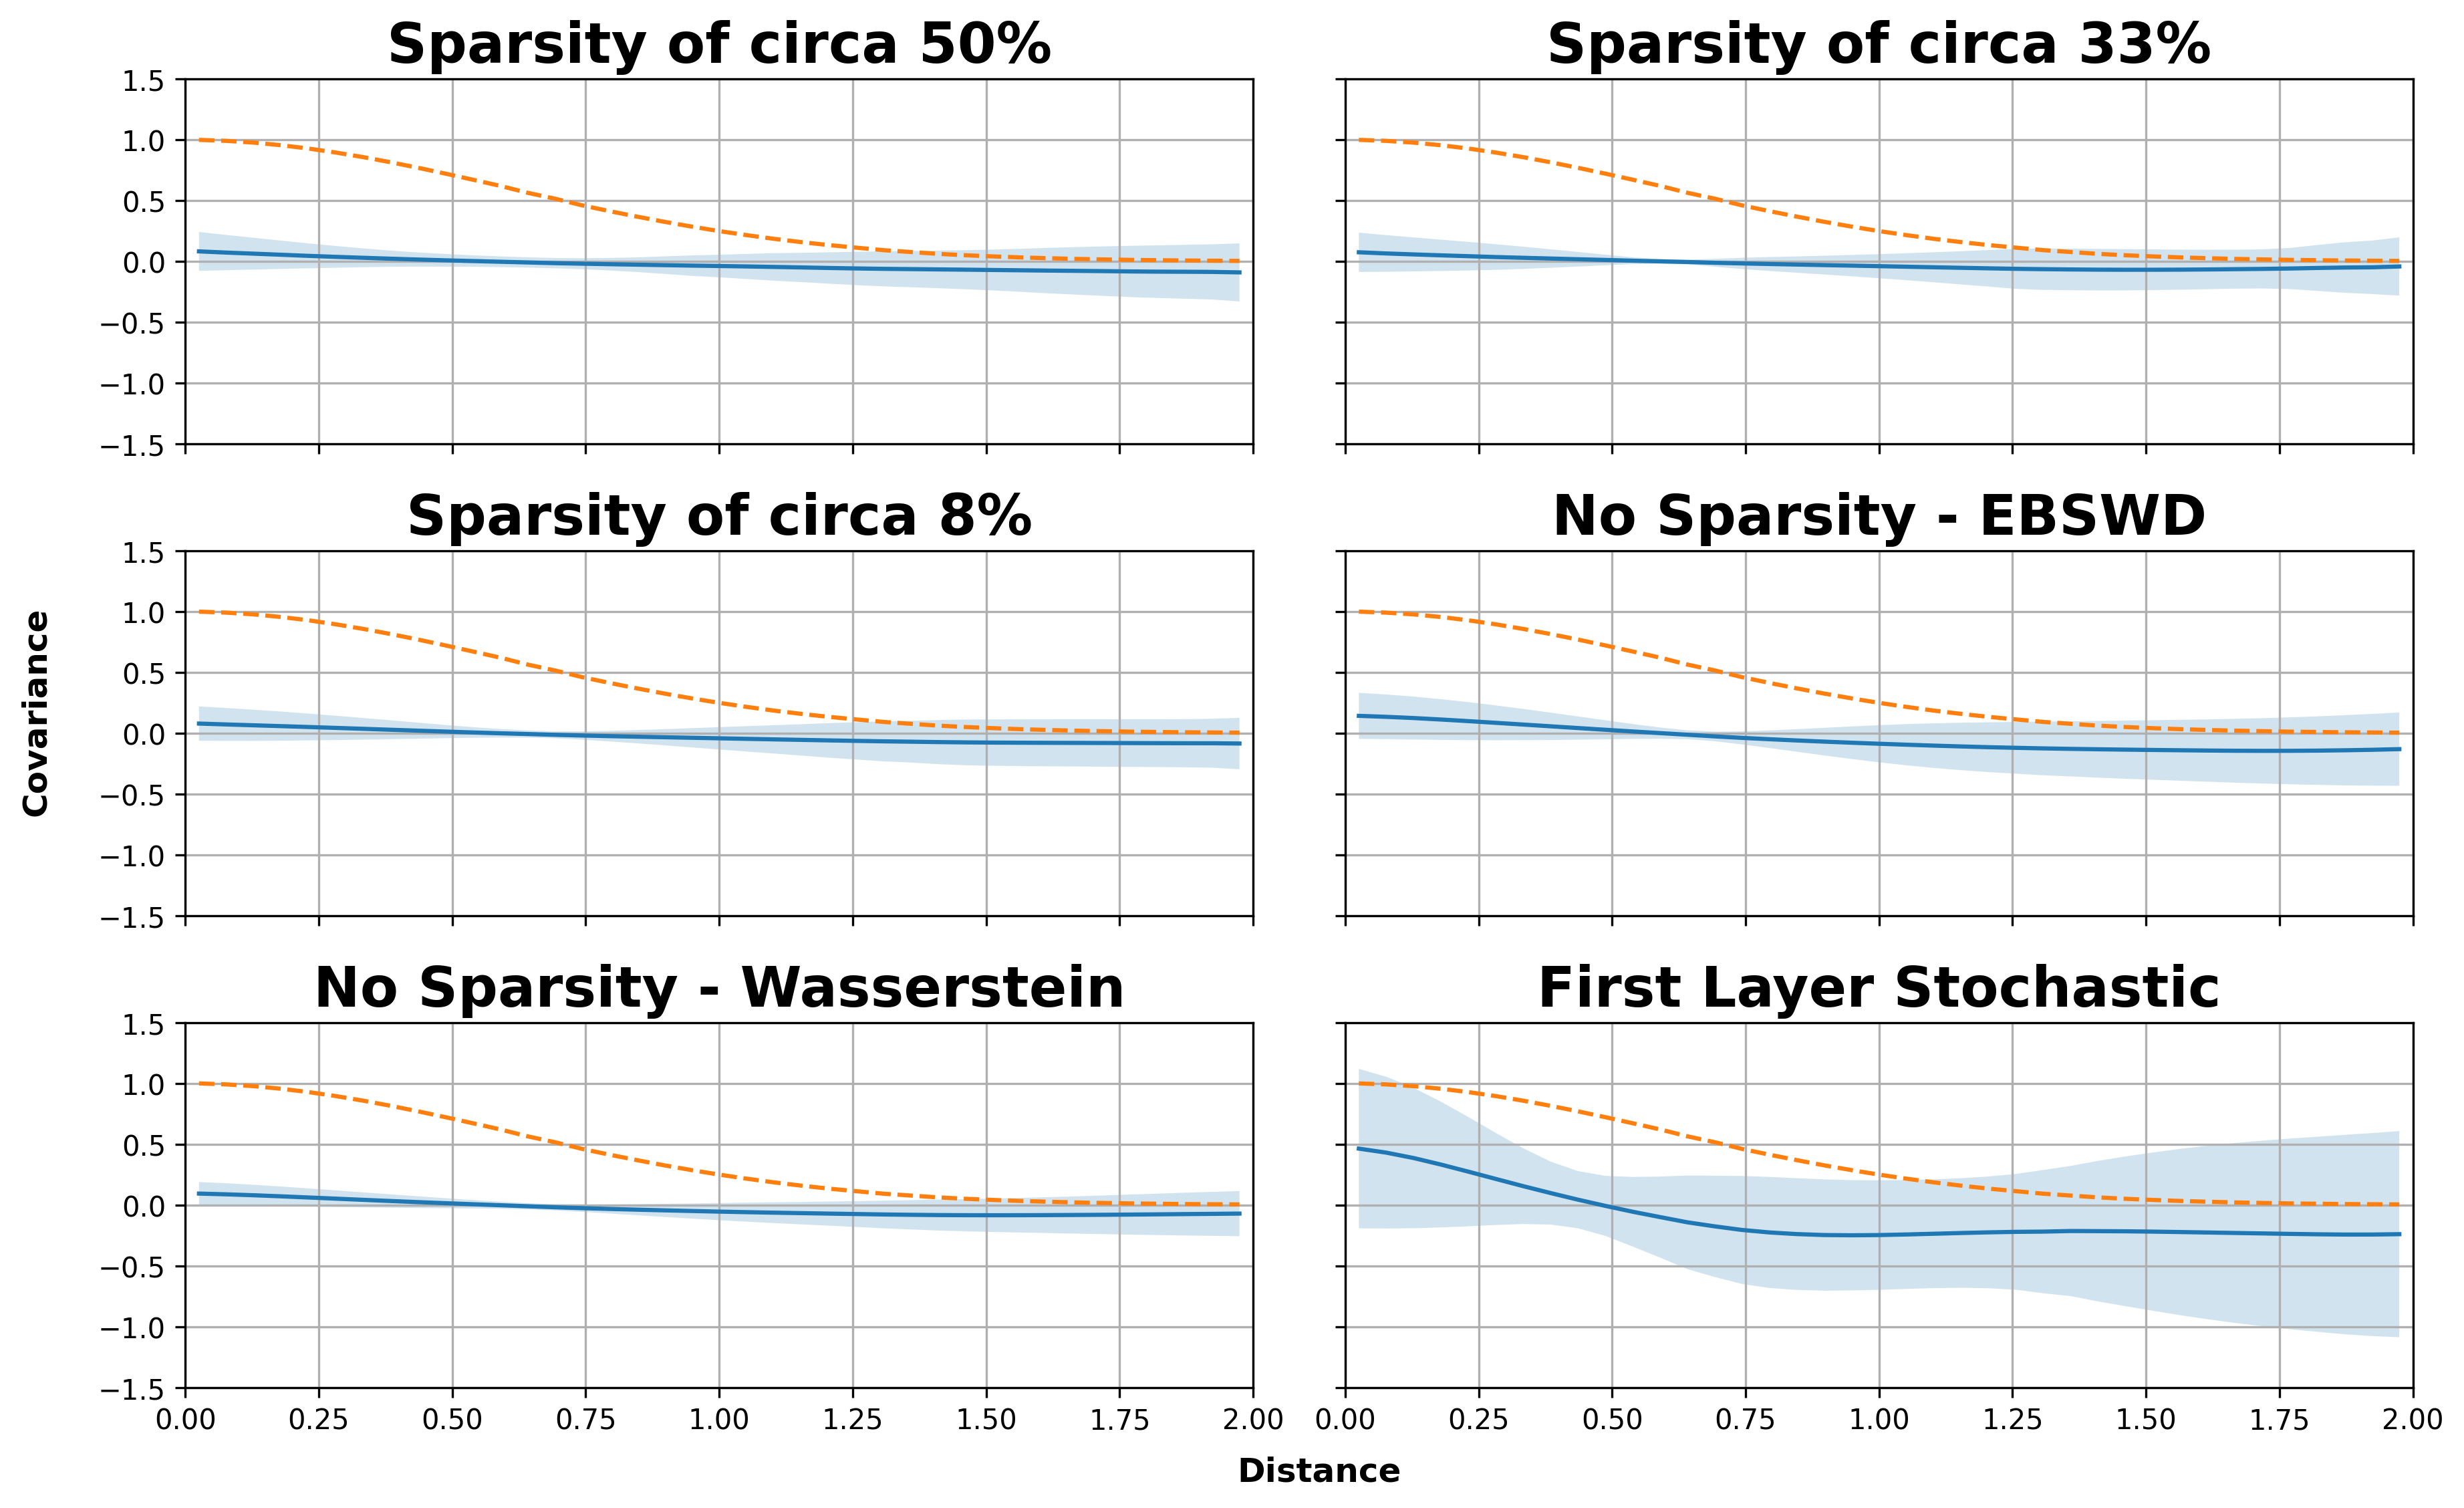

In [ ]:
def compute_sample_covariance(sample, X, bins=None):
    sample = sample.flatten()
    X_np = X_dist.detach().cpu().numpy().flatten()

    # Distance matrix
    dist_matrix = np.abs(X_np[:, None] - X_np[None, :])

    # Mean-center
    sample_centered = sample - np.mean(sample)
    pairwise_cov = np.outer(sample_centered, sample_centered)

    if bins is None:
        unique_dists = np.unique(dist_matrix)
        cov_vs_dist = np.array([
            pairwise_cov[dist_matrix == d].mean() for d in unique_dists
        ])
        return unique_dists, cov_vs_dist
    else:
        dist_flat = dist_matrix.flatten()
        cov_flat = pairwise_cov.flatten()
        digitized = np.digitize(dist_flat, bins)
        cov_vs_dist = np.array([
            cov_flat[digitized == i].mean() if np.any(digitized == i) else np.nan
            for i in range(1, len(bins))
        ])
        dist_centers = 0.5 * (bins[:-1] + bins[1:])
        return dist_centers, cov_vs_dist


def compute_kernel_covariance(kernel, X, bins=None):
    X_np = X_dist.detach().cpu().numpy().flatten()
    dist_matrix = np.abs(X_np[:, None] - X_np[None, :])
    K = kernel.K(X, X).detach().cpu().numpy()

    if bins is None:
        unique_dists = np.unique(dist_matrix)
        kernel_cov = np.array([
            K[dist_matrix == d].mean() for d in unique_dists
        ])
        return unique_dists, kernel_cov
    else:
        dist_flat = dist_matrix.flatten()
        K_flat = K.flatten()
        digitized = np.digitize(dist_flat, bins)
        kernel_cov = np.array([
            K_flat[digitized == i].mean() if np.any(digitized == i) else np.nan
            for i in range(1, len(bins))
        ])
        dist_centers = 0.5 * (bins[:-1] + bins[1:])
        return dist_centers, kernel_cov

X_dist = torch.linspace(0, 2, 100).view(-1, 1).to(device)
n_plot = 100

# Sample function outputs
sparse_opt_samples_variogram = (
    opt_bnn_sp.sample_functions(X_dist.float(), n_plot)
    .squeeze().detach().cpu().numpy()
) 
sparse_opt_samples_level2_variogram = (
    opt_bnn_sp_level2.sample_functions(X_dist.float(), n_plot)
    .squeeze().detach().cpu().numpy()
) 
sparse_opt_samples_level3_variogram = (
    opt_bnn_sp_level3.sample_functions(X_dist.float(), n_plot)
    .squeeze().detach().cpu().numpy()
) 
opt_samples_ebswd_variogram = (
    opt_bnn_fs_ebswd.sample_functions(X_dist.float(), n_plot)
    .squeeze().detach().cpu().numpy()
) 
opt_samples_wasserstein = (
    opt_bnn_fs.sample_functions(X_dist.float(), n_plot)
    .squeeze().detach().cpu().numpy()
) 
opt_samples_fls= (
    opt_bnn_fls.sample_functions(X_dist.float(), n_plot)
    .squeeze().detach().cpu().numpy()
) 

sample_sets = {
    "Sparsity of circa 50%": sparse_opt_samples_variogram,
    "Sparsity of circa 33%": sparse_opt_samples_level2_variogram,
    "Sparsity of circa 8%": sparse_opt_samples_level3_variogram,
    "No Sparsity - EBSWD": opt_samples_ebswd_variogram,
    "No Sparsity - Wasserstein" : opt_samples_wasserstein,
    "First Layer Stochastic": opt_samples_fls
}

# Define distance bins for smoother curves
bins = np.linspace(0, 2, 40)

# Kernel covariance reference
kernel_dists, kernel_covs = compute_kernel_covariance(kernel, X_dist, bins=bins)

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (name, samples_np) in enumerate(sample_sets.items()):
    sample_covariances = []

    for i in range(samples_np.shape[1]): 
        dists, covs = compute_sample_covariance(samples_np[:, i], X_dist, bins=bins)
        sample_covariances.append(covs)

    arr = np.array(sample_covariances) 
    mean_cov_avg = np.nanmean(arr, axis=0)
    std_cov_avg = np.nanstd(arr, axis=0)

    ax = axes[idx]
    ax.plot(dists, mean_cov_avg, label="Empirical covariance")
    ax.fill_between(
        dists,
        mean_cov_avg - std_cov_avg,
        mean_cov_avg + std_cov_avg,
        alpha=0.2
    )
    ax.plot(kernel_dists, kernel_covs, '--', label="RBF kernel covariance")

    ax.set_title(name, fontsize=20, fontweight='bold')
    ax.grid(True)
    ax.set_xlim(left=0)
    ax.set_xlim(right=2)
    ax.set_ylim([-1.5,1.5])

fig.text(0.52, 0.02, "Distance", ha="center", fontsize=12, fontweight='bold')
fig.text(-0.02, 0.5, "Covariance", va="center", rotation="vertical", fontsize=12, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig_path = os.path.join(FIG_DIR, "variogram")
plt.savefig(fig_path)
plt.show()

# Posterior Inference

In [ ]:
# SGHMC Hyper-parameters
sampling_configs_ps = {
    "batch_size": 64,            # Mini-batch size
    "num_samples": 30,           # Total number of samples for each chain
    "n_discarded": 10,           # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 1500,   # Number of burn-in steps, 2000 yields better MSE
    "keep_every": 200,           # Thinning interval
    "lr": 0.03,                  # Step size
    "num_chains": 4,             # Number of chains
    "mdecay": 0.02,              # Momentum coefficient
    "print_every_n_samples": 5,  # After how many iterations an evaluation should be printed
    "lambd": 5e-6                # The lambda for encouraging sparsity in the deterministic weights
}

with open(os.path.join(OUT_DIR_PS, "masks_list.pkl"), "rb") as f:
    weights_mask_sp, bias_mask_sp = pickle.load(f)
ckpt_path_sp = os.path.join(OUT_DIR_PS, "ckpts", "it-{}.ckpt".format(num_iters_sp))
prior_optim_sp = OptimGaussianPrior(ckpt_path_sp)
checkpoint = torch.load(ckpt_path_sp)
W_std_list = []
b_std_list = []
W_std_out = 1
b_std_out = 1
for key, value in checkpoint.items():
    if key == "out_b_standdev":
        b_std_out = value
    elif key == "out_W_standdev":
        W_std_out = value
    elif "W_std" in key:
        W_std_list.append(value)
    elif "b_std" in key:
        b_std_list.append(value)
# Setup of the likelihood and network
likelihood = LikGaussian(sn2)

## Optimized Prior for Partial Stochasticity

### Training the Deterministic Weights before Inference

In [37]:
# Load the optimized prior
util.set_seed(1)

net_optim_psb = MLPMPSNF(1, 1, [width]*depth, transfer_fn, weights_mask_sp, bias_mask_sp, D = D, 
                       prior_W_std_list = W_std_list, prior_b_std_list = b_std_list, 
                        W_std_out = W_std_out, b_std_out = b_std_out, device=device)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR_PS, "sampling_optim_before")
util.ensure_dir(saved_dir)
psb_net_optim = RegressionNetMasked(net_optim_psb, likelihood, prior_optim_sp, saved_dir, n_gpu=n_gpu)
# Start sampling
sampling_configs_psb = sampling_configs_ps
sampling_configs_psb["train_det"] = "before"
sampling_configs_psb["det_train_steps"] = 2000
psb_net_optim.sample_multi_chains(X, y, **sampling_configs_psb)

Chain: 1
Samples #     5 : NLL =  3.1298e-01 RMSE = 2.7504e-01  
 Pruned deterministic weights: 136
Samples #    10 : NLL =  3.0863e-01 RMSE = 2.7177e-01  
 Pruned deterministic weights: 136
Samples #    15 : NLL =  3.0011e-01 RMSE = 2.6954e-01  
 Pruned deterministic weights: 136
Samples #    20 : NLL =  2.9207e-01 RMSE = 2.6014e-01  
 Pruned deterministic weights: 136
Samples #    25 : NLL =  2.9385e-01 RMSE = 2.5904e-01  
 Pruned deterministic weights: 136
Chain: 2
Samples #    30 : NLL =  2.9165e-01 RMSE = 2.5729e-01  
 Pruned deterministic weights: 136
Samples #    35 : NLL =  2.8612e-01 RMSE = 2.5122e-01  
 Pruned deterministic weights: 136
Samples #    40 : NLL =  2.8045e-01 RMSE = 2.4446e-01  
 Pruned deterministic weights: 136
Samples #    45 : NLL =  2.7953e-01 RMSE = 2.4283e-01  
 Pruned deterministic weights: 136
Samples #    50 : NLL =  2.7823e-01 RMSE = 2.4113e-01  
 Pruned deterministic weights: 136
Samples #    55 : NLL =  2.7799e-01 RMSE = 2.4066e-01  
 Pruned determin

In [38]:
# Make predictions
_, _, psb_optim_preds = psb_net_optim.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(psb_optim_preds, sampling_configs_psb["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
psb_optim_preds = psb_optim_preds.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(OUT_DIR_PS, "posterior_optim_before.npz")
np.savez(posterior_optim_path, bnn_samples=psb_optim_preds)

R-hat: mean 1.1680 std 0.1403


### Training the Deterministic Weights During Inference

**Level of Sparsity of crica 50%**

In [39]:
# Set the seed
util.set_seed(1)

# Setup of the network
net_optim_psd = MLPMPS(1, 1, [width]*depth, transfer_fn, weights_mask_sp, bias_mask_sp, D = D, 
                       prior_W_std_list = W_std_list, prior_b_std_list = b_std_list, 
                        W_std_out = W_std_out, b_std_out = b_std_out, device=device)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR_PS, "sampling_optim_during")
util.ensure_dir(saved_dir)
psd_net_optim = RegressionNetMasked(net_optim_psd, likelihood, prior_optim_sp, saved_dir, n_gpu=n_gpu)
# Start sampling
sampling_configs_psd = sampling_configs_ps
sampling_configs_psd["train_det"] = "during"
sampling_configs_psd["det_train_steps"] = 2000
psd_net_optim.sample_multi_chains(X, y, **sampling_configs_psd)

Chain: 1
Samples #     5 : NLL =  2.1343e-01 RMSE = 2.3127e-01  
 Pruned deterministic weights: 176
Samples #    10 : NLL =  2.2238e-01 RMSE = 2.3398e-01  
 Pruned deterministic weights: 179
Samples #    15 : NLL =  2.3154e-01 RMSE = 2.3546e-01  
 Pruned deterministic weights: 184
Samples #    20 : NLL =  2.8325e-01 RMSE = 2.4571e-01  
 Pruned deterministic weights: 192
Samples #    25 : NLL =  3.3387e-01 RMSE = 2.6532e-01  
 Pruned deterministic weights: 198
Chain: 2
Samples #    30 : NLL =  3.2618e-01 RMSE = 2.6383e-01  
 Pruned deterministic weights: 196
Samples #    35 : NLL =  3.1471e-01 RMSE = 2.5887e-01  
 Pruned deterministic weights: 199
Samples #    40 : NLL =  3.1296e-01 RMSE = 2.5910e-01  
 Pruned deterministic weights: 202
Samples #    45 : NLL =  3.0749e-01 RMSE = 2.5798e-01  
 Pruned deterministic weights: 209
Samples #    50 : NLL =  3.0803e-01 RMSE = 2.5700e-01  
 Pruned deterministic weights: 214
Samples #    55 : NLL =  3.0867e-01 RMSE = 2.5771e-01  
 Pruned determin

In [40]:
# Make predictions
_, _, psd_optim_preds = psd_net_optim.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(psd_optim_preds, sampling_configs_psd["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
psd_optim_preds = psd_optim_preds.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(OUT_DIR_PS, "posterior_optim_during.npz")
np.savez(posterior_optim_path, bnn_samples=psd_optim_preds)

R-hat: mean 1.0288 std 0.0453


**Level of Sparsity of circa 33%**

In [41]:
# Set the seed
util.set_seed(1)
with open(os.path.join(saved_dir_ps_level2, "masks_list.pkl"), "rb") as f:
    weights_mask_sp_level2, bias_mask_sp_level2 = pickle.load(f)
ckpt_path_sp_level2 = os.path.join(saved_dir_ps_level2, "ckpts", "it-{}.ckpt".format(num_iters_sp))
prior_optim_sp_level2 = OptimGaussianPrior(ckpt_path_sp_level2)
checkpoint_level2 = torch.load(ckpt_path_sp_level2)
W_std_list_level2 = []
b_std_list_level2 = []
W_std_out_level2 = 1
b_std_out_level2 = 1
for key, value in checkpoint_level2.items():
    if key == "out_b_standdev":
        b_std_out_level2 = value
    elif key == "out_W_standdev":
        W_std_out_level2 = value
    elif "W_std" in key:
        W_std_list_level2.append(value)
    elif "b_std" in key:
        b_std_list_level2.append(value)
# Setup of the network
net_optim_psd_level2 = MLPMPS(1, 1, [width]*depth, transfer_fn, weights_mask_sp_level2, bias_mask_sp_level2, D = D, 
                       prior_W_std_list = W_std_list_level2, prior_b_std_list = b_std_list_level2, 
                        W_std_out = W_std_out_level2, b_std_out = b_std_out_level2, device=device)
# Initialize the sampler
saved_dir = os.path.join(saved_dir_ps_level2, "sampling_optim_during_level2")
util.ensure_dir(saved_dir)
psd_net_optim_level2 = RegressionNetMasked(net_optim_psd_level2, likelihood, prior_optim_sp, saved_dir, n_gpu=n_gpu)
# Start sampling
psd_net_optim_level2.sample_multi_chains(X, y, **sampling_configs_psd)

Chain: 1
Samples #     5 : NLL =  2.2763e-01 RMSE = 2.3706e-01  
 Pruned deterministic weights: 155
Samples #    10 : NLL =  2.3554e-01 RMSE = 2.3466e-01  
 Pruned deterministic weights: 158
Samples #    15 : NLL =  2.2495e-01 RMSE = 2.2688e-01  
 Pruned deterministic weights: 161
Samples #    20 : NLL =  2.3172e-01 RMSE = 2.2967e-01  
 Pruned deterministic weights: 163
Samples #    25 : NLL =  2.2473e-01 RMSE = 2.2427e-01  
 Pruned deterministic weights: 171
Chain: 2
Samples #    30 : NLL =  2.2480e-01 RMSE = 2.2392e-01  
 Pruned deterministic weights: 176
Samples #    35 : NLL =  2.2253e-01 RMSE = 2.2185e-01  
 Pruned deterministic weights: 177
Samples #    40 : NLL =  2.2100e-01 RMSE = 2.2122e-01  
 Pruned deterministic weights: 177
Samples #    45 : NLL =  2.2221e-01 RMSE = 2.2173e-01  
 Pruned deterministic weights: 180
Samples #    50 : NLL =  2.2629e-01 RMSE = 2.2328e-01  
 Pruned deterministic weights: 182
Samples #    55 : NLL =  2.2655e-01 RMSE = 2.2145e-01  
 Pruned determin

In [42]:
# Make predictions
_, _, psd_optim_preds_level2 = psd_net_optim_level2.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(psd_optim_preds_level2, sampling_configs_psd["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
psd_optim_preds_level2 = psd_optim_preds_level2.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(saved_dir_ps_level2, "posterior_optim_during.npz")
np.savez(posterior_optim_path, bnn_samples=psd_optim_preds_level2)

R-hat: mean 1.0602 std 0.0462


**Level of Sparsity of circa 8%**

In [43]:
# Set the seed
util.set_seed(1)
with open(os.path.join(saved_dir_ps_level3, "masks_list.pkl"), "rb") as f:
    weights_mask_sp_level3, bias_mask_sp_level3 = pickle.load(f)
ckpt_path_sp_level3 = os.path.join(saved_dir_ps_level3, "ckpts", "it-{}.ckpt".format(num_iters_sp))
prior_optim_sp_level3 = OptimGaussianPrior(ckpt_path_sp_level3)
checkpoint_level3 = torch.load(ckpt_path_sp_level3)
W_std_list_level3 = []
b_std_list_level3 = []
W_std_out_level3 = 1
b_std_out_level3 = 1
for key, value in checkpoint_level3.items():
    if key == "out_b_standdev":
        b_std_out_level3 = value
    elif key == "out_W_standdev":
        W_std_out_level3 = value
    elif "W_std" in key:
        W_std_list_level3.append(value)
    elif "b_std" in key:
        b_std_list_level3.append(value)
# Setup of the network
net_optim_psd_level3 = MLPMPS(1, 1, [width]*depth, transfer_fn, weights_mask_sp_level3, bias_mask_sp_level3, D = D, 
                       prior_W_std_list = W_std_list_level3, prior_b_std_list = b_std_list_level3, 
                        W_std_out = W_std_out_level3, b_std_out = b_std_out_level3, device=device)
# Initialize the sampler
saved_dir = os.path.join(saved_dir_ps_level3, "sampling_optim_during_level3")
util.ensure_dir(saved_dir)
psd_net_optim_level3 = RegressionNetMasked(net_optim_psd_level3, likelihood, prior_optim_sp, saved_dir, n_gpu=n_gpu)
# Start sampling
psd_net_optim_level3.sample_multi_chains(X, y, **sampling_configs_psd)

Chain: 1
Samples #     5 : NLL =  2.2981e-01 RMSE = 2.4356e-01  
 Pruned deterministic weights: 50
Samples #    10 : NLL =  2.2106e-01 RMSE = 2.2745e-01  
 Pruned deterministic weights: 53
Samples #    15 : NLL =  2.1892e-01 RMSE = 2.2668e-01  
 Pruned deterministic weights: 58
Samples #    20 : NLL =  2.1872e-01 RMSE = 2.2513e-01  
 Pruned deterministic weights: 61
Samples #    25 : NLL =  2.1414e-01 RMSE = 2.2024e-01  
 Pruned deterministic weights: 63
Chain: 2
Samples #    30 : NLL =  2.1403e-01 RMSE = 2.1879e-01  
 Pruned deterministic weights: 63
Samples #    35 : NLL =  2.2145e-01 RMSE = 2.2108e-01  
 Pruned deterministic weights: 65
Samples #    40 : NLL =  2.2479e-01 RMSE = 2.2321e-01  
 Pruned deterministic weights: 68
Samples #    45 : NLL =  2.2349e-01 RMSE = 2.2238e-01  
 Pruned deterministic weights: 70
Samples #    50 : NLL =  2.2501e-01 RMSE = 2.2355e-01  
 Pruned deterministic weights: 72
Samples #    55 : NLL =  2.2628e-01 RMSE = 2.2454e-01  
 Pruned deterministic weig

In [44]:
# Make predictions
_, _, psd_optim_preds_level3 = psd_net_optim_level3.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(psd_optim_preds_level3, sampling_configs_psd["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
psd_optim_preds_level3 = psd_optim_preds_level3.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(saved_dir_ps_level3, "posterior_optim_during.npz")
np.savez(posterior_optim_path, bnn_samples=psd_optim_preds_level3)

R-hat: mean 1.0327 std 0.0500


**No Sparsity**

In [45]:
# SGHMC Hyper-parameters
sampling_configs_fs_ebswd = {
    "batch_size": 32,           # Mini-batch size
    "num_samples": 30,          # Total number of samples for each chain
    "n_discarded": 10,          # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,  # Number of burn-in steps, 2000 yields better MSE
    "keep_every": 200,          # Thinning interval
    "lr": 0.01,                 # Step size
    "num_chains": 4,            # Number of chains
    "mdecay": 0.01,             # Momentum coefficient
    "print_every_n_samples": 5
}

In [46]:
# Load the optimized prior
util.set_seed(1)
ckpt_path = os.path.join(OUT_DIR_EBSWD_FS, "ckpts", "it-{}.ckpt".format(num_iters_sp))
prior_fs_ebswd = OptimGaussianPrior(ckpt_path)
# Setup of the network
net_optim_fs_ebswd = MLP(1, 1, [width]*depth, transfer_fn)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR_EBSWD_FS, "sampling_optim")
util.ensure_dir(saved_dir)
fs_net_optim_ebswd = RegressionNet(net_optim_fs_ebswd, likelihood, prior_fs_ebswd, saved_dir, n_gpu=n_gpu)
# Start sampling
fs_net_optim_ebswd.sample_multi_chains(X, y, **sampling_configs_fs_ebswd)

Chain: 0
Samples #     5 : NLL =  3.0178e-01 RMSE = 2.5296e-01 
Samples #    10 : NLL =  2.8695e-01 RMSE = 2.2995e-01 
Samples #    15 : NLL =  2.9853e-01 RMSE = 2.2375e-01 
Samples #    20 : NLL =  2.9644e-01 RMSE = 2.1779e-01 
Chain: 1
Samples #    25 : NLL =  3.0467e-01 RMSE = 2.1988e-01 
Samples #    30 : NLL =  3.0487e-01 RMSE = 2.1877e-01 
Samples #    35 : NLL =  3.2264e-01 RMSE = 2.1662e-01 
Samples #    40 : NLL =  3.4408e-01 RMSE = 2.1630e-01 
Chain: 2
Samples #    45 : NLL =  3.3569e-01 RMSE = 2.1251e-01 
Samples #    50 : NLL =  3.3003e-01 RMSE = 2.1197e-01 
Samples #    55 : NLL =  3.2538e-01 RMSE = 2.0954e-01 
Samples #    60 : NLL =  3.2325e-01 RMSE = 2.0811e-01 
Chain: 3
Samples #    65 : NLL =  3.1850e-01 RMSE = 2.0685e-01 
Samples #    70 : NLL =  3.1566e-01 RMSE = 2.0611e-01 
Samples #    75 : NLL =  3.1400e-01 RMSE = 2.0577e-01 
Samples #    80 : NLL =  3.1481e-01 RMSE = 2.0603e-01 


In [47]:
# Make predictions
_, _, fs_optim_preds_ebswd = fs_net_optim_ebswd.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(fs_optim_preds_ebswd, sampling_configs_fs_ebswd["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
fs_optim_preds_ebswd = fs_optim_preds_ebswd.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(OUT_DIR_EBSWD_FS, "posterior_optim.npz")
np.savez(posterior_optim_path, bnn_samples=fs_optim_preds_ebswd)

R-hat: mean 1.0387 std 0.0703


### Training the Deterministic Weights After Inference

In [48]:
# Set the seed
util.set_seed(1)

# Setup of the network
net_optim_psa = MLPMPS(1, 1, [width]*depth, transfer_fn, weights_mask_sp, bias_mask_sp, D = D, 
                       prior_W_std_list = W_std_list, prior_b_std_list = b_std_list, 
                        W_std_out = W_std_out, b_std_out = b_std_out, device=device)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR_PS, "sampling_optim_after")
util.ensure_dir(saved_dir)
psa_net_optim = RegressionNetMasked(net_optim_psa, likelihood, prior_optim_sp, saved_dir, n_gpu=n_gpu)
# Start sampling
sampling_configs_psa = sampling_configs_ps
sampling_configs_psa["train_det"] = "after"
sampling_configs_psa["det_train_steps"] = 2000
psa_net_optim.sample_multi_chains(X, y, **sampling_configs_psa)

Chain: 1
Samples #     5 : NLL =  3.2667e-01 RMSE = 3.0017e-01  
 Pruned deterministic weights: 0
Samples #    10 : NLL =  3.1852e-01 RMSE = 2.9287e-01  
 Pruned deterministic weights: 0
Samples #    15 : NLL =  3.1654e-01 RMSE = 2.9181e-01  
 Pruned deterministic weights: 0
Samples #    20 : NLL =  3.2611e-01 RMSE = 2.9538e-01  
 Pruned deterministic weights: 0
Samples #    25 : NLL =  3.2637e-01 RMSE = 2.9400e-01  
 Pruned deterministic weights: 0
Chain: 2
Samples #    30 : NLL =  3.3136e-01 RMSE = 2.9687e-01  
 Pruned deterministic weights: 0
Samples #    35 : NLL =  3.3311e-01 RMSE = 2.9720e-01  
 Pruned deterministic weights: 0
Samples #    40 : NLL =  3.4049e-01 RMSE = 3.0067e-01  
 Pruned deterministic weights: 0
Samples #    45 : NLL =  3.4004e-01 RMSE = 3.0148e-01  
 Pruned deterministic weights: 0
Samples #    50 : NLL =  3.4011e-01 RMSE = 3.0166e-01  
 Pruned deterministic weights: 0
Samples #    55 : NLL =  3.3673e-01 RMSE = 2.9953e-01  
 Pruned deterministic weights: 0
Cha

In [49]:
# Make predictions
_, _, psa_optim_preds = psa_net_optim.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(psa_optim_preds, sampling_configs_psa["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
psa_optim_preds = psa_optim_preds.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(OUT_DIR_PS, "posterior_optim_after.npz")
np.savez(posterior_optim_path, bnn_samples=psa_optim_preds)

R-hat: mean 1.0483 std 0.0452


### Training Sparse BNN

In [50]:
# Sampling configurations
sampling_configs_sp = {
    "batch_size": 16,              
    "num_samples": 30,
    "n_discarded": 10,
    "num_burn_in_steps": 1500,
    "keep_every": 200,             
    "lr": 0.02,                     
    "num_chains": 4,
    "mdecay": 0.015,
    "print_every_n_samples": 5
}

In [51]:
# Set the seed
util.set_seed(1)

# Setup the network
net_optim_sp = MLPMFS(1, 1, [width]*depth, transfer_fn, weights_mask_sp, bias_mask_sp, device=device)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR_PSS, "sampling_optim")
util.ensure_dir(saved_dir)
sp_net_optim = RegressionNet(net_optim_sp, likelihood, prior_optim_sp, saved_dir, n_gpu=n_gpu)
# Start sampling
sp_net_optim.sample_multi_chains(X, y, **sampling_configs_sp)

Chain: 0
Samples #     5 : NLL =  3.5485e-01 RMSE = 2.6830e-01 
Samples #    10 : NLL =  3.6311e-01 RMSE = 2.2919e-01 
Samples #    15 : NLL =  3.3688e-01 RMSE = 2.2535e-01 
Samples #    20 : NLL =  3.3542e-01 RMSE = 2.2125e-01 
Chain: 1
Samples #    25 : NLL =  3.3566e-01 RMSE = 2.2206e-01 
Samples #    30 : NLL =  3.3112e-01 RMSE = 2.2279e-01 
Samples #    35 : NLL =  3.3227e-01 RMSE = 2.2205e-01 
Samples #    40 : NLL =  3.3357e-01 RMSE = 2.2718e-01 
Chain: 2
Samples #    45 : NLL =  3.3766e-01 RMSE = 2.2720e-01 
Samples #    50 : NLL =  3.3473e-01 RMSE = 2.2786e-01 
Samples #    55 : NLL =  3.3063e-01 RMSE = 2.2915e-01 
Samples #    60 : NLL =  3.2847e-01 RMSE = 2.2946e-01 
Chain: 3
Samples #    65 : NLL =  3.2417e-01 RMSE = 2.2945e-01 
Samples #    70 : NLL =  3.2249e-01 RMSE = 2.2848e-01 
Samples #    75 : NLL =  3.1786e-01 RMSE = 2.2854e-01 
Samples #    80 : NLL =  3.1729e-01 RMSE = 2.2927e-01 


In [52]:
# Make predictions
_, _, sp_optim_preds = sp_net_optim.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(sp_optim_preds, sampling_configs_sp["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
sp_optim_preds = sp_optim_preds.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(OUT_DIR_PSS, "posterior_optim.npz")
np.savez(posterior_optim_path, bnn_samples=sp_optim_preds)

R-hat: mean 1.0121 std 0.0326


## Optimized Prior for Full BNN

In [53]:
# SGHMC Hyper-parameters
sampling_configs_fs = {
    "batch_size": 32,           # Mini-batch size
    "num_samples": 30,          # Total number of samples for each chain
    "n_discarded": 10,          # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,  # Number of burn-in steps, 2000 yields better MSE
    "keep_every": 200,          # Thinning interval
    "lr": 0.01,                 # Step size
    "num_chains": 4,            # Number of chains
    "mdecay": 0.01,             # Momentum coefficient
    "print_every_n_samples": 5
}

In [54]:
# Load the optimized prior
util.set_seed(1)
ckpt_path = os.path.join(OUT_DIR_FS, "ckpts", "it-{}.ckpt".format(mapper_num_iters))
prior_fs = OptimGaussianPrior(ckpt_path)
# Setup of the network
net_optim_fs = MLP(1, 1, [width]*depth, transfer_fn)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR_FS, "sampling_optim")
util.ensure_dir(saved_dir)
fs_net_optim = RegressionNet(net_optim_fs, likelihood, prior_fs, saved_dir, n_gpu=n_gpu)
# Start sampling
fs_net_optim.sample_multi_chains(X, y, **sampling_configs_fs)

Chain: 0
Samples #     5 : NLL =  2.8323e-01 RMSE = 2.8369e-01 
Samples #    10 : NLL =  2.6533e-01 RMSE = 2.6710e-01 
Samples #    15 : NLL =  2.5945e-01 RMSE = 2.6225e-01 
Samples #    20 : NLL =  2.5497e-01 RMSE = 2.6087e-01 
Chain: 1
Samples #    25 : NLL =  2.5405e-01 RMSE = 2.5970e-01 
Samples #    30 : NLL =  2.5094e-01 RMSE = 2.5806e-01 
Samples #    35 : NLL =  2.4857e-01 RMSE = 2.5682e-01 
Samples #    40 : NLL =  2.5085e-01 RMSE = 2.5738e-01 
Chain: 2
Samples #    45 : NLL =  2.5153e-01 RMSE = 2.5705e-01 
Samples #    50 : NLL =  2.5283e-01 RMSE = 2.5846e-01 
Samples #    55 : NLL =  2.5512e-01 RMSE = 2.5867e-01 
Samples #    60 : NLL =  2.5694e-01 RMSE = 2.5877e-01 
Chain: 3
Samples #    65 : NLL =  2.5628e-01 RMSE = 2.5820e-01 
Samples #    70 : NLL =  2.5696e-01 RMSE = 2.5881e-01 
Samples #    75 : NLL =  2.5706e-01 RMSE = 2.5908e-01 
Samples #    80 : NLL =  2.5862e-01 RMSE = 2.5961e-01 


In [55]:
# Make predictions
_, _, fs_optim_preds = fs_net_optim.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(fs_optim_preds, sampling_configs_fs["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
fs_optim_preds = fs_optim_preds.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(OUT_DIR_FS, "posterior_optim.npz")
np.savez(posterior_optim_path, bnn_samples=fs_optim_preds)

R-hat: mean 1.0136 std 0.0260


## Optimized Prior First Layer Stochastic

In [56]:
# SGHMC Hyper-parameters
sampling_configs_fls = {
    "batch_size": 32,           # Mini-batch size
    "num_samples": 30,          # Total number of samples for each chain
    "n_discarded": 10,          # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 2000,  # Number of burn-in steps, 2000 yields better MSE
    "keep_every": 200,          # Thinning interval
    "lr": 0.01,                 # Step size
    "num_chains": 4,            # Number of chains
    "mdecay": 0.01,             # Momentum coefficient
    "print_every_n_samples": 5
}

In [57]:
# Load the optimized prior
util.set_seed(1)
ckpt_path_fls = os.path.join(OUT_DIR_FLS, "ckpts", "it-{}.ckpt".format(mapper_num_iters_fls))
prior_optim_fls = OptimGaussianPrior(ckpt_path_fls)

# Setup of the network
net_optim_fls = StochMLP(1, 1, [width]*depth, transfer_fn)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR_FLS, "sampling_optim")
util.ensure_dir(saved_dir)
fls_net_optim = RegressionNetMasked(net_optim_fls, likelihood, prior_optim_fls, saved_dir, n_gpu=n_gpu)
# Start sampling
fls_net_optim.sample_multi_chains(X, y, **sampling_configs_fls)

Chain: 1
Samples #     5 : NLL =  1.8327e-01 RMSE = 2.2924e-01  
 Pruned deterministic weights: 0
Samples #    10 : NLL =  1.8385e-01 RMSE = 2.2835e-01  
 Pruned deterministic weights: 0
Samples #    15 : NLL =  1.8263e-01 RMSE = 2.2667e-01  
 Pruned deterministic weights: 0
Samples #    20 : NLL =  1.8295e-01 RMSE = 2.2709e-01  
 Pruned deterministic weights: 0
Samples #    25 : NLL =  1.8355e-01 RMSE = 2.2717e-01  
 Pruned deterministic weights: 0
Samples #    30 : NLL =  1.8303e-01 RMSE = 2.2726e-01  
 Pruned deterministic weights: 0
Chain: 2
Samples #    35 : NLL =  1.8379e-01 RMSE = 2.2833e-01  
 Pruned deterministic weights: 0
Samples #    40 : NLL =  1.8372e-01 RMSE = 2.2884e-01  
 Pruned deterministic weights: 0
Samples #    45 : NLL =  1.8341e-01 RMSE = 2.2848e-01  
 Pruned deterministic weights: 0
Samples #    50 : NLL =  1.8283e-01 RMSE = 2.2831e-01  
 Pruned deterministic weights: 0
Samples #    55 : NLL =  1.8130e-01 RMSE = 2.2739e-01  
 Pruned deterministic weights: 0
Sam

In [58]:
# Make predictions
_, _, fls_optim_preds = fls_net_optim.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(fls_optim_preds, sampling_configs_fls["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
fls_optim_preds = fls_optim_preds.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(OUT_DIR_FLS, "posterior_optim.npz")
np.savez(posterior_optim_path, bnn_samples=fls_optim_preds)

R-hat: mean 1.0202 std 0.0445


# Visualize Predictive Posterior

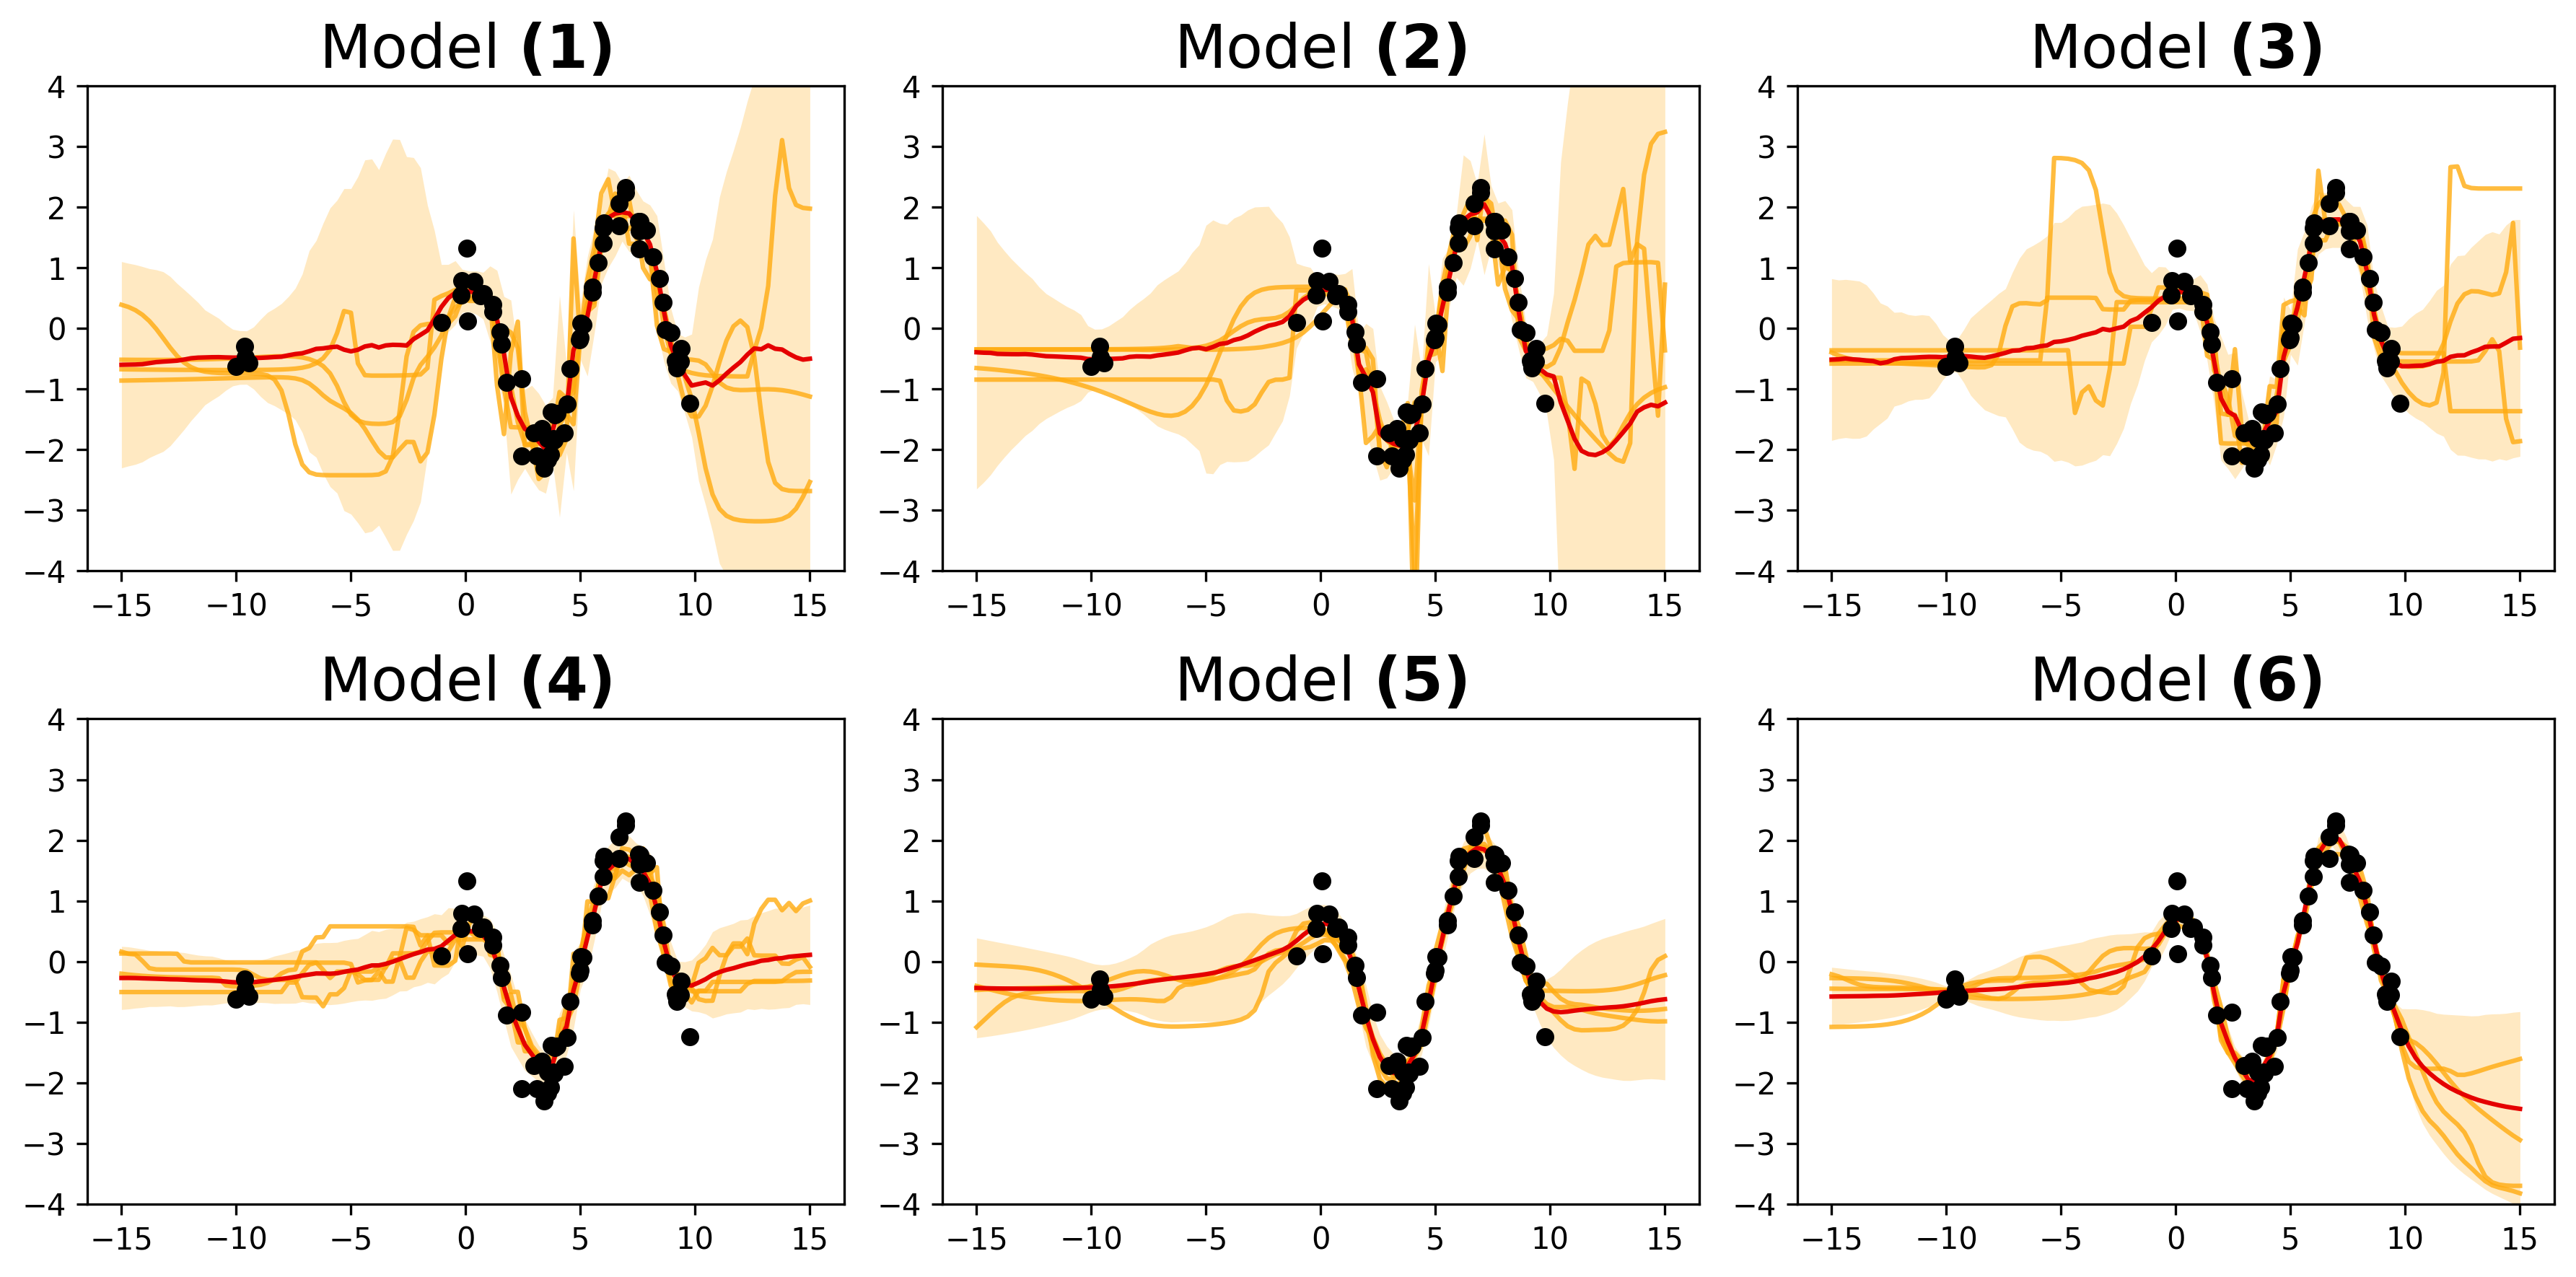

In [59]:
util.set_seed(4)

fig, axs = plt.subplots(2,3, figsize=(12, 6))

plot_samples(Xtest, sp_optim_preds, ax = axs[0,0], color='xkcd:yellowish orange', n_keep=4)
axs[0,0].plot(X, y, 'ok', zorder=10, ms=5)
axs[0,0].set_title(r'Model $\mathbf{(1)}$', fontsize = 20)
axs[0,0].set_ylim([-4, 4])

plot_samples(Xtest, psb_optim_preds, ax = axs[0,1], color = 'xkcd:yellowish orange', n_keep=4)
axs[0,1].plot(X, y, 'ok', zorder=10, ms=5)
axs[0,1].set_title(r'Model $\mathbf{(2)}$', fontsize = 20)
axs[0,1].set_ylim([-4, 4])

plot_samples(Xtest, psd_optim_preds, ax = axs[0,2], color = 'xkcd:yellowish orange', n_keep=4)
axs[0,2].plot(X, y, 'ok', zorder=10, ms=5)
axs[0,2].set_title(r'Model $\mathbf{(3)}$', fontsize = 20)
axs[0,2].set_ylim([-4, 4])

plot_samples(Xtest, psa_optim_preds, ax = axs[1,0], color = 'xkcd:yellowish orange', n_keep=4)
axs[1,0].plot(X, y, 'ok', zorder=10, ms=5)
axs[1,0].set_title(r'Model $\mathbf{(4)}$', fontsize = 20)
axs[1,0].set_ylim([-4, 4])

plot_samples(Xtest, fs_optim_preds, ax = axs[1,1], color='xkcd:yellowish orange', n_keep=4)
axs[1,1].plot(X, y, 'ok', zorder=10, ms=5)
axs[1,1].set_title(r'Model $\mathbf{(5)}$', fontsize = 20)
axs[1,1].set_ylim([-4, 4])

plot_samples(Xtest, fls_optim_preds, ax = axs[1,2], color='xkcd:yellowish orange', n_keep=4)
axs[1,2].plot(X, y, 'ok', zorder=10, ms=5)
axs[1,2].set_title(r'Model $\mathbf{(6)}$', fontsize = 20)
axs[1,2].set_ylim([-4, 4])

plt.tight_layout()
fig_path = os.path.join(FIG_DIR, "predictive_posterior")
plt.savefig(fig_path)
plt.show()

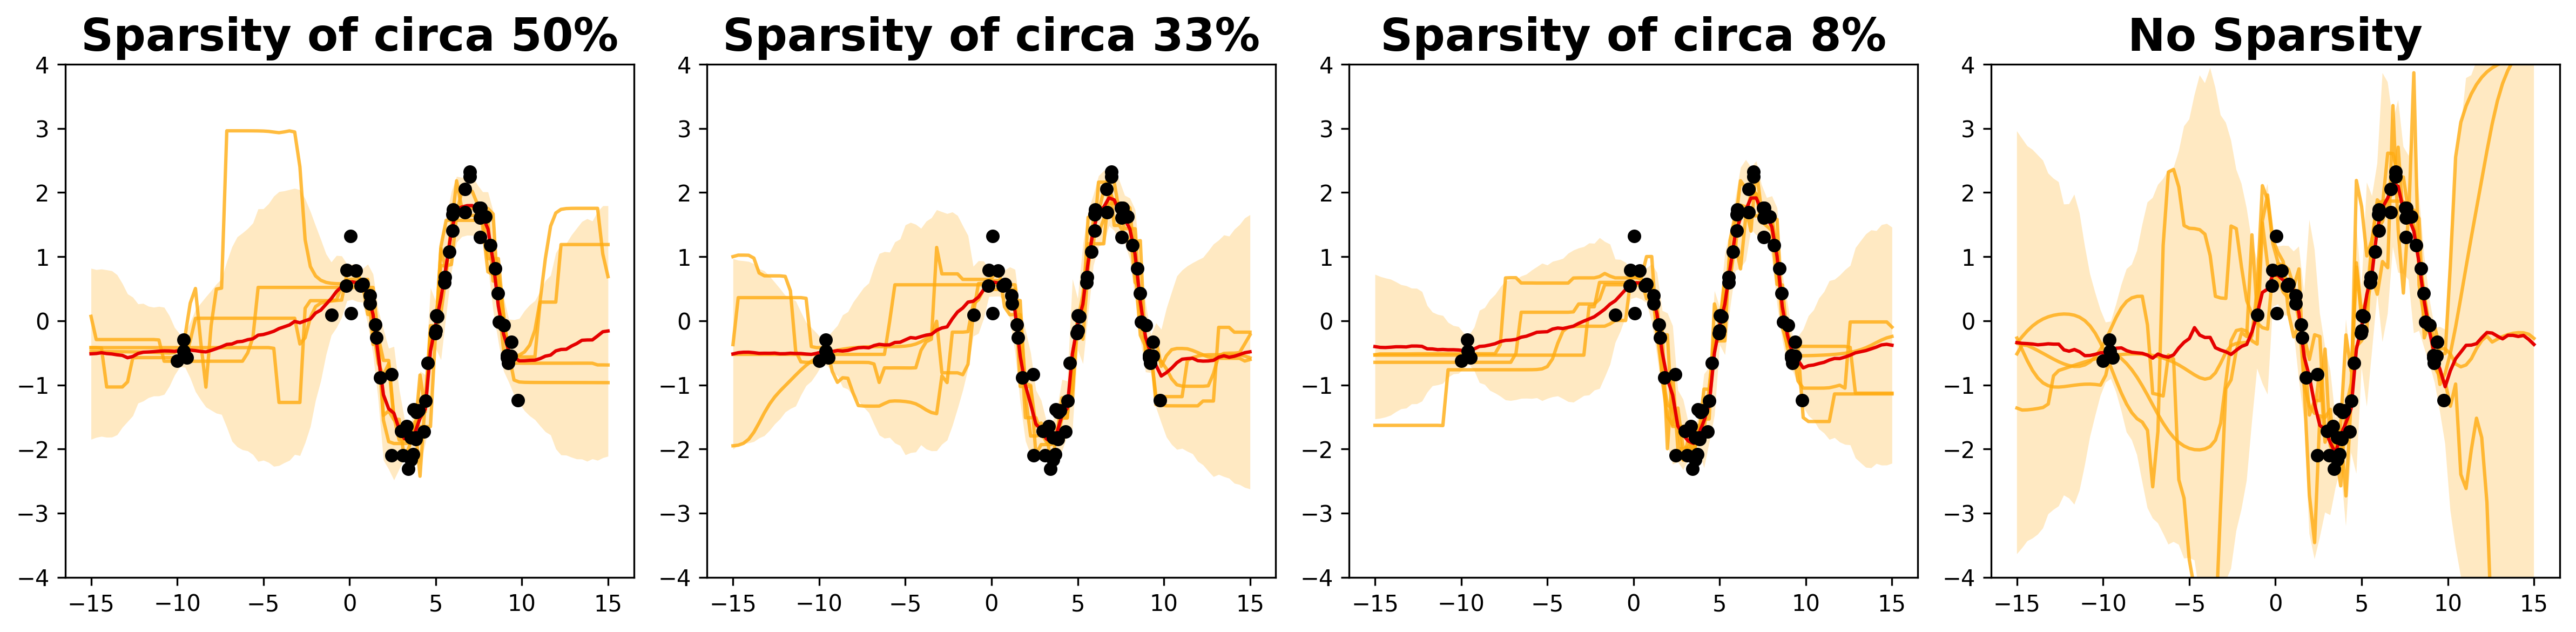

In [60]:
util.set_seed(4)

fig, axs = plt.subplots(1,4, figsize=(16, 4))

plot_samples(Xtest, psd_optim_preds, ax = axs[0], color='xkcd:yellowish orange', n_keep=4)
axs[0].plot(X, y, 'ok', zorder=10, ms=5)
axs[0].set_title('Sparsity of circa 50%', fontsize = 20, fontweight = 'bold')
axs[0].set_ylim([-4, 4])

plot_samples(Xtest, psd_optim_preds_level2, ax = axs[1], color='xkcd:yellowish orange', n_keep=4)
axs[1].plot(X, y, 'ok', zorder=10, ms=5)
axs[1].set_title('Sparsity of circa 33%', fontsize = 20, fontweight = 'bold')
axs[1].set_ylim([-4, 4])

plot_samples(Xtest, psd_optim_preds_level3, color = 'xkcd:yellowish orange', ax = axs[2], n_keep=4)
axs[2].plot(X, y, 'ok', zorder=10, ms=5)
axs[2].set_title('Sparsity of circa 8%', fontsize = 20, fontweight = 'bold')
axs[2].set_ylim([-4, 4])

plot_samples(Xtest, fs_optim_preds_ebswd, color = 'xkcd:yellowish orange', ax = axs[3], n_keep=4)
axs[3].plot(X, y, 'ok', zorder=10, ms=5)
axs[3].set_title('No Sparsity', fontsize = 20, fontweight = 'bold')
axs[3].set_ylim([-4, 4])

plt.tight_layout()
fig_path = os.path.join(FIG_DIR, "predictive_posterior_sparsity_comparison")
plt.savefig(fig_path)
plt.show()